<a href="https://colab.research.google.com/github/OWL-408/CIT2024/blob/main/%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E3%83%AA%E3%83%B3%E3%82%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cluster labels for each dataset: [0 0 0 0 0 0 1 2 0]


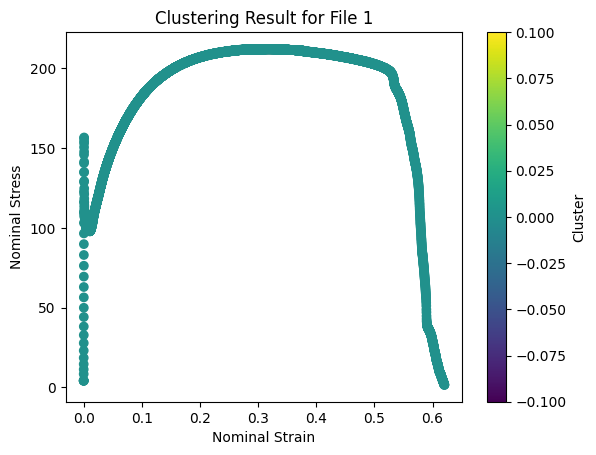

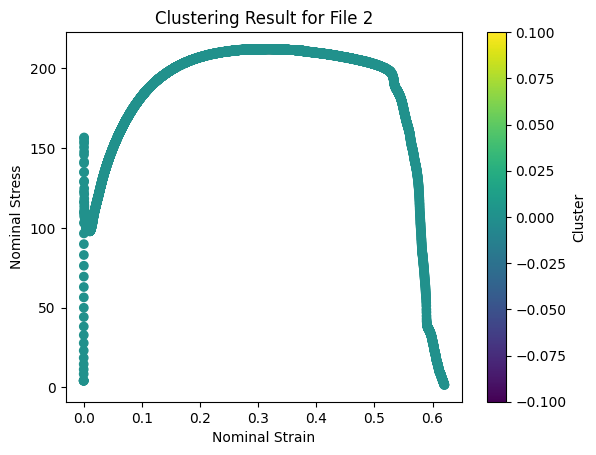

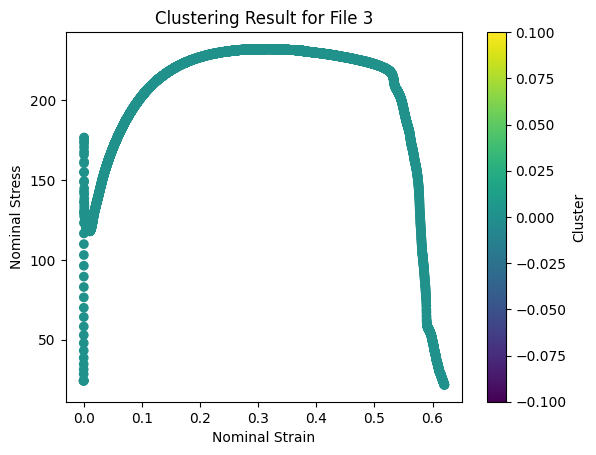

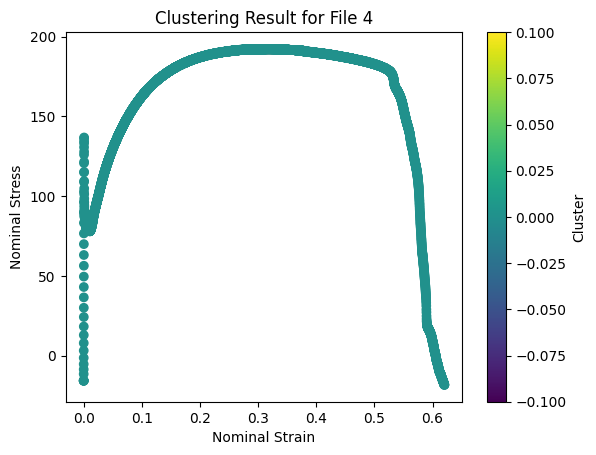

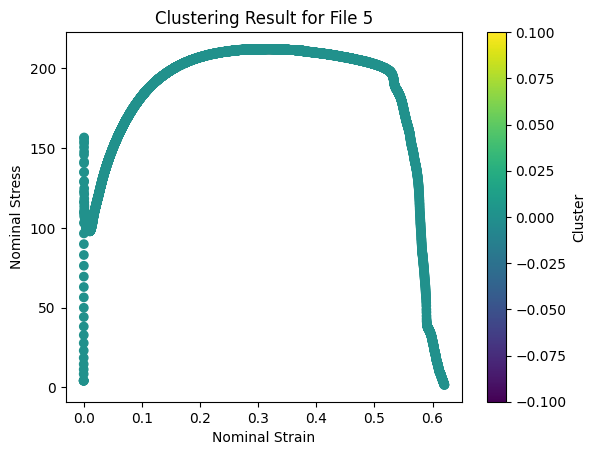

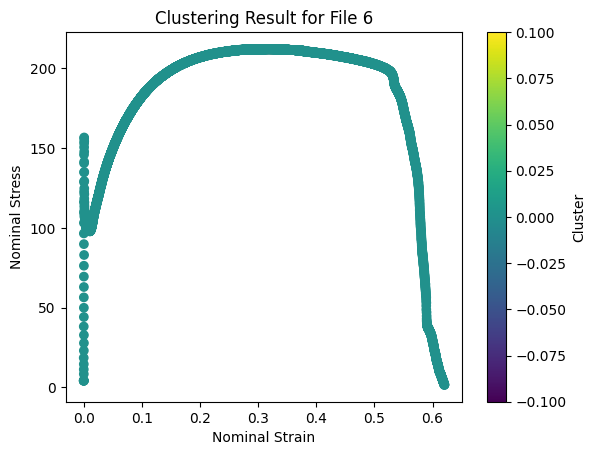

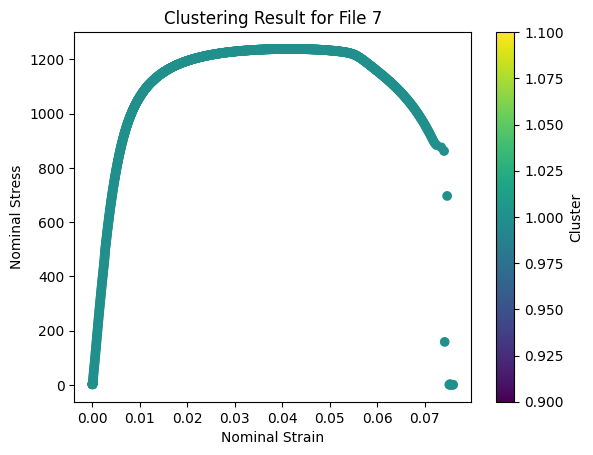

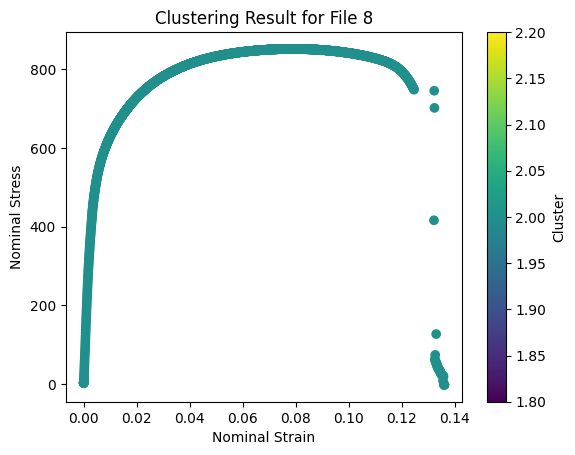

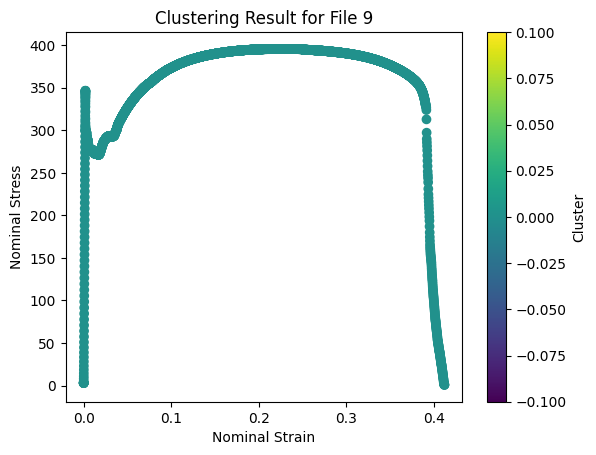

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from scipy.stats import linregress

# 複数のCSVファイルを対象に同じディレクトリ内のファイルを読み込む
file_paths = glob.glob('//content/drive/MyDrive/clustering/*.csv')

# 全データの特徴量を保持するリスト
features_list = []

# 各CSVファイルを処理
for file_path in file_paths:
    df = pd.read_csv(file_path)
    if 'Nominal strain' not in df.columns or 'Nominal stress' not in df.columns:
        continue  # 必要なカラムがない場合スキップ

    strain = df['Nominal strain'].values
    stress = df['Nominal stress'].values
    # 線形近似による傾き（ここでは全範囲で計算）
    slope, intercept, r_value, p_value, std_err = linregress(strain, stress)

    # ここでは1つの特徴量（傾き）のみとする
    features_list.append([slope])

# 全特徴量データをNumPy配列に変換
features_array = np.array(features_list)

# スケーリング
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)

# クラスタリング
kmeans = KMeans(n_clusters=3, random_state=0).fit(features_scaled)
labels = kmeans.labels_

# 結果の出力
print("Cluster labels for each dataset:", labels)

# 結果の可視化
for i, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    plt.figure()
    plt.scatter(df['Nominal strain'], df['Nominal stress'], label=f'File {i+1}', c=np.full(len(df), labels[i]), cmap='viridis', marker='o')
    plt.xlabel('Nominal Strain')
    plt.ylabel('Nominal Stress')
    plt.title(f'Clustering Result for File {i+1}')
    plt.colorbar(label='Cluster')
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

データの読み込みと特徴抽出中...

クラスタリングの実行中...

結果の可視化...


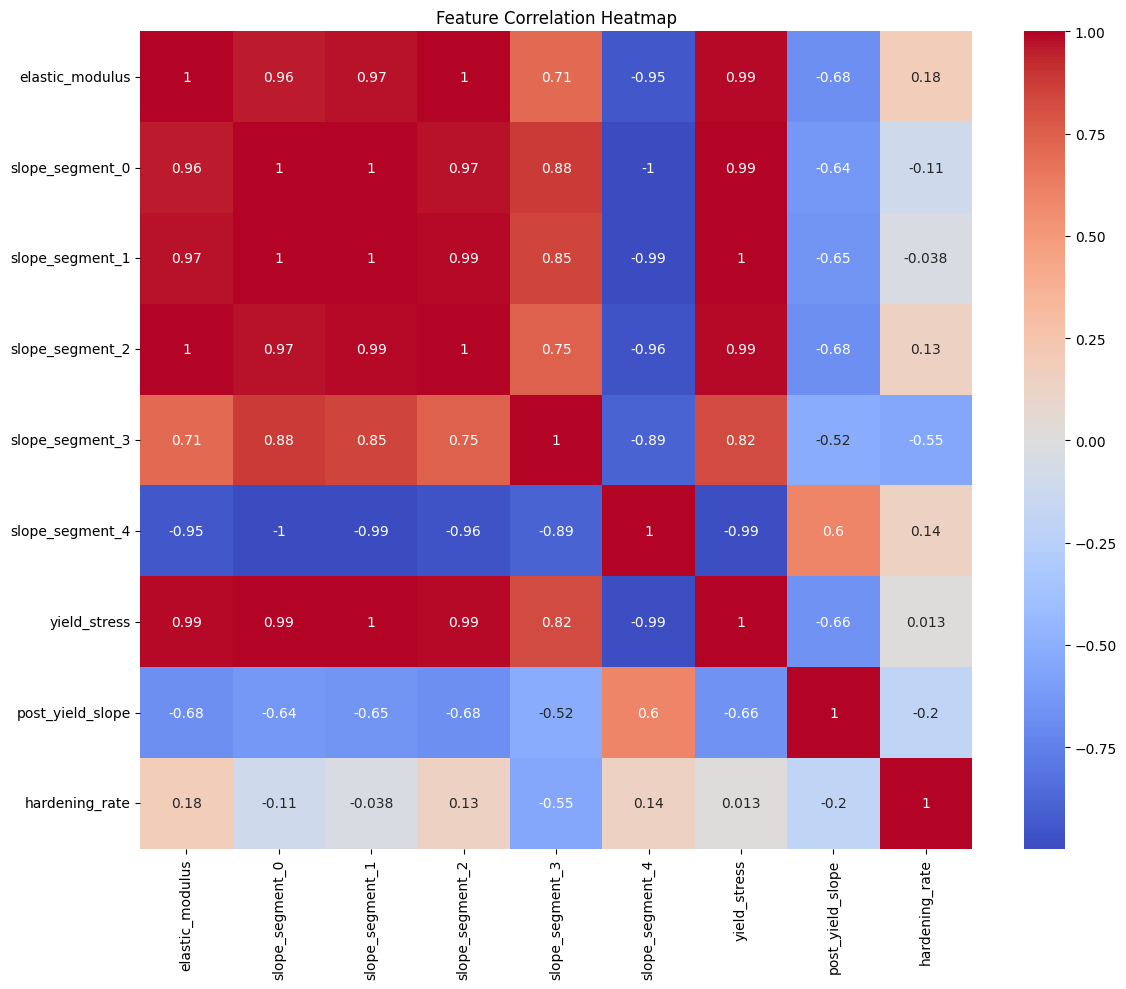

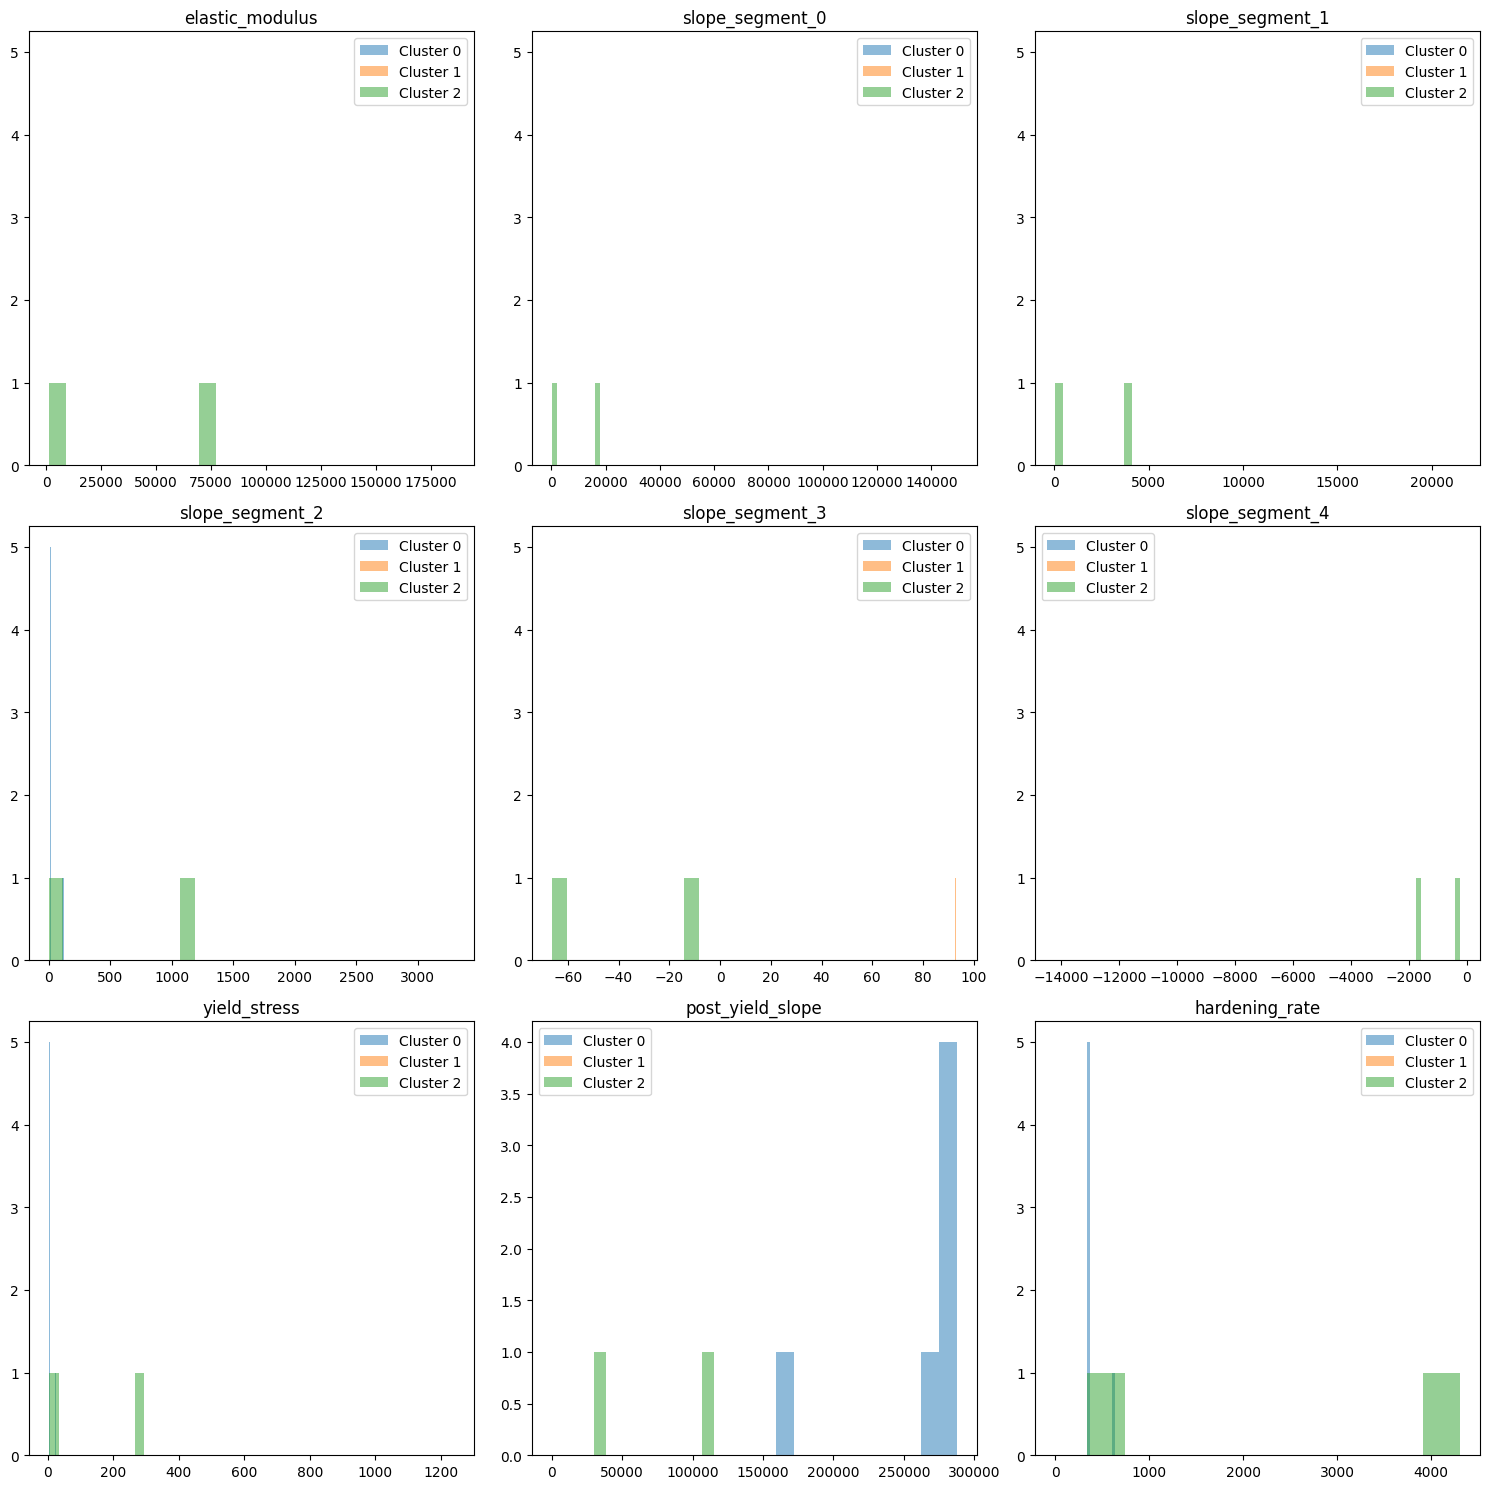


Clustering Results:

Cluster 0 contains 6 curves:

Average features:
elastic_modulus: 1384.47
slope_segment_0: 929.80
slope_segment_1: 301.18
slope_segment_2: 29.62
slope_segment_3: -22.93
slope_segment_4: -720.52
yield_stress: 7.50
post_yield_slope: 263002.22
hardening_rate: 392.07

Files in this cluster:
  - F_time_augmented0.1.csv
  - F_time_shortened0.1.csv
  - F_stress_increase_augmented20.csv
  - F_stress_decrease_augmented20.csv
  - F_time_Lengthened0.1.csv
  - F-P.csv

Cluster 1 contains 1 curves:

Average features:
elastic_modulus: 185420.63
slope_segment_0: 149328.74
slope_segment_1: 21484.25
slope_segment_2: 3290.96
slope_segment_3: 92.79
slope_segment_4: -14210.71
yield_stress: 1237.93
post_yield_slope: 0.00
hardening_rate: 0.00

Files in this cluster:
  - M.csv

Cluster 2 contains 2 curves:

Average features:
elastic_modulus: 39162.05
slope_segment_0: 9063.05
slope_segment_1: 2081.95
slope_segment_2: 593.86
slope_segment_3: -37.30
slope_segment_4: -982.54
yield_stress: 14

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import linregress
from scipy.signal import savgol_filter

class TrendBasedClustering:
    def __init__(self, n_clusters=3):
        """
        応力ひずみ曲線のトレンドに基づくクラスタリング分析クラス

        Parameters:
        -----------
        n_clusters : int
            クラスタ数
        """
        self.file_paths = glob.glob('//content/drive/MyDrive/clustering/*.csv')
        self.n_clusters = n_clusters
        self.trend_features = {}
        self.feature_matrix = None
        self.labels = None

    def extract_trend_features(self, strain, stress):
        """
        応力ひずみ曲線からトレンド特徴を抽出する

        Parameters:
        -----------
        strain : array-like
            ひずみデータ
        stress : array-like
            応力データ

        Returns:
        --------
        dict : トレンド特徴量
        """
        features = {}

        # データの前処理
        stress_smooth = savgol_filter(stress, window_length=11, polyorder=3)

        # 初期弾性率（初期の傾き）
        elastic_range = int(len(strain) * 0.1)
        slope_elastic, _, _, _, _ = linregress(strain[:elastic_range], stress[:elastic_range])
        features['elastic_modulus'] = slope_elastic

        # 変化率（応力/ひずみ）の計算
        stress_diff = np.diff(stress_smooth)
        strain_diff = np.diff(strain)
        rates = stress_diff / (strain_diff + 1e-10)  # ゼロ除算を防ぐ

        # 各領域の傾きを計算
        n_segments = 5
        segment_size = len(rates) // n_segments
        for i in range(n_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_rates = rates[start_idx:end_idx]
            features[f'slope_segment_{i}'] = np.median(segment_rates)

        # 降伏点と降伏後の傾き
        offset_strain = strain + 0.002
        offset_stress = slope_elastic * offset_strain
        stress_diff = stress - offset_stress
        yield_idx = np.where(stress_diff > 0)[0]
        if len(yield_idx) > 0:
            yield_point = yield_idx[0]
            features['yield_stress'] = stress[yield_point]
            if yield_point < len(strain) - 10:
                post_yield_slope, _, _, _, _ = linregress(
                    strain[yield_point:yield_point+10],
                    stress[yield_point:yield_point+10]
                )
                features['post_yield_slope'] = post_yield_slope
        else:
            features['yield_stress'] = np.max(stress)
            features['post_yield_slope'] = 0

        max_stress_idx = np.argmax(stress)
        if 'yield_point' in locals() and max_stress_idx > yield_point:
            hardening_slope, _, _, _, _ = linregress(
                strain[yield_point:max_stress_idx],
                stress[yield_point:max_stress_idx]
            )
            features['hardening_rate'] = hardening_slope
        else:
            features['hardening_rate'] = 0

        return features

    def load_and_extract_features(self):
        """
        データの読み込みとトレンド特徴の抽出
        """
        features_list = []
        file_names = []

        for file_path in self.file_paths:
            try:
                df = pd.read_csv(file_path)
                if 'Nominal strain' not in df.columns or 'Nominal stress' not in df.columns:
                    print(f"Warning: Required columns not found in {file_path}")
                    continue

                strain = df['Nominal strain'].values
                stress = df['Nominal stress'].values

                # トレンド特徴の抽出
                features = self.extract_trend_features(strain, stress)
                features_list.append(features)
                file_names.append(os.path.basename(file_path))

            except Exception as e:
                print(f"Error processing {file_path}: {str(e)}")

        # 特徴量行列の作成
        self.feature_matrix = pd.DataFrame(features_list, index=file_names)
        return self.feature_matrix

    def perform_clustering(self):
        """
        トレンド特徴に基づいてクラスタリングを実行する
        """
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.feature_matrix)

        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.labels = kmeans.fit_predict(features_scaled)

        return self.labels

    def visualize_results(self):
        """
        クラスタリング結果を可視化する
        """
        plt.figure(figsize=(12, 10))
        sns.heatmap(self.feature_matrix.corr(), cmap='coolwarm', center=0, annot=True)
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()

        feature_names = list(self.feature_matrix.columns)
        n_features = len(feature_names)
        n_rows = (n_features + 2) // 3

        plt.figure(figsize=(15, 5 * n_rows))
        for i, feature in enumerate(feature_names):
            plt.subplot(n_rows, 3, i + 1)
            for j in range(self.n_clusters):
                cluster_data = self.feature_matrix[feature][self.labels == j]
                plt.hist(cluster_data, alpha=0.5, label=f'Cluster {j}')
            plt.title(feature)
            plt.legend()

        plt.tight_layout()
        plt.show()

        print("\nClustering Results:")
        for i in range(self.n_clusters):
            cluster_files = [name for j, name in enumerate(self.feature_matrix.index)
                           if self.labels[j] == i]
            print(f"\nCluster {i} contains {len(cluster_files)} curves:")

            cluster_means = self.feature_matrix.loc[cluster_files].mean()
            print("\nAverage features:")
            for feature, value in cluster_means.items():
                print(f"{feature}: {value:.2f}")

            print("\nFiles in this cluster:")
            for file in cluster_files:
                print(f"  - {file}")

    def run_analysis(self):
        """
        全解析プロセスを実行する
        """
        print("データの読み込みと特徴抽出中...")
        self.load_and_extract_features()

        print("\nクラスタリングの実行中...")
        self.perform_clustering()

        print("\n結果の可視化...")
        self.visualize_results()

        return self.feature_matrix, self.labels

# 使用例
if __name__ == "__main__":
    clustering = TrendBasedClustering(n_clusters=3)
    feature_matrix, labels = clustering.run_analysis()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import linregress
from scipy.signal import savgol_filter

class TrendBasedClustering:
    def __init__(self, directory_path, n_clusters=3):
        self.directory_path = directory_path
        self.n_clusters = n_clusters
        self.file_paths = glob.glob(os.path.join(directory_path, '*.csv'))
        self.feature_matrix = None
        self.labels = None

    def extract_trend_features(self, strain, stress):
        features = {}
        stress_smooth = savgol_filter(stress, window_length=11, polyorder=3)
        elastic_range = int(len(strain) * 0.1)
        slope_elastic, _, _, _, _ = linregress(strain[:elastic_range], stress[:elastic_range])
        features['elastic_modulus'] = slope_elastic
        stress_diff = np.diff(stress_smooth)
        strain_diff = np.diff(strain)
        rates = stress_diff / (strain_diff + 1e-10)
        n_segments = 5
        segment_size = len(rates) // n_segments
        for i in range(n_segments):
            start_idx = i * segment_size
            end_idx = (i + 1) * segment_size
            segment_rates = rates[start_idx:end_idx]
            features[f'slope_segment_{i}'] = np.median(segment_rates)
        offset_strain = strain + 0.002
        offset_stress = slope_elastic * offset_strain
        stress_diff = stress - offset_stress
        yield_idx = np.where(stress_diff > 0)[0]
        if len(yield_idx) > 0:
            yield_point = yield_idx[0]
            features['yield_stress'] = stress[yield_point]
            if yield_point < len(strain) - 10:
                post_yield_slope, _, _, _, _ = linregress(
                    strain[yield_point:yield_point+10],
                    stress[yield_point:yield_point+10]
                )
                features['post_yield_slope'] = post_yield_slope
        else:
            features['yield_stress'] = np.max(stress)
            features['post_yield_slope'] = 0
        max_stress_idx = np.argmax(stress)
        if yield_point < max_stress_idx:
            hardening_slope, _, _, _, _ = linregress(
                strain[yield_point:max_stress_idx],
                stress[yield_point:max_stress_idx]
            )
            features['hardening_rate'] = hardening_slope
        else:
            features['hardening_rate'] = 0
        return features

    def load_and_extract_features(self):
        features_list = []
        file_names = []
        for file_path in self.file_paths:
            df = pd.read_csv(file_path)
            if 'Nominal strain' not in df.columns or 'Nominal stress' not in df.columns:
                print(f"Warning: Required columns not found in {file_path}")
                continue
            strain = df['Nominal strain'].values
            stress = df['Nominal stress'].values
            features = self.extract_trend_features(strain, stress)
            features_list.append(features)
            file_names.append(os.path.basename(file_path))
        self.feature_matrix = pd.DataFrame(features_list, index=file_names)
        return self.feature_matrix

    def perform_clustering(self):
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(self.feature_matrix)
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.labels = kmeans.fit_predict(features_scaled)
        return self.labels

    def plot_cluster_map(self, method='PCA'):
        if self.feature_matrix is None or self.labels is None:
            print("Error: Feature matrix or labels not found. Run clustering first.")
            return

        if method == 'PCA':
            reducer = PCA(n_components=2)
        else:
            raise ValueError("Method must be 'PCA'")

        reduced_features = reducer.fit_transform(self.feature_matrix)

        plt.figure(figsize=(10, 8))
        for i in range(self.n_clusters):
            cluster_points = reduced_features[self.labels == i]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

        plt.title(f'Cluster Map ({method})')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        plt.show()

    def run_analysis(self):
        print("データの読み込みと特徴抽出中...")
        self.load_and_extract_features()

        print("\nクラスタリングの実行中...")
        self.perform_clustering()

        print("\nクラスターマップの表示...")
        self.plot_cluster_map(method='PCA')

        return self.feature_matrix, self.labels

# 使用例
if __name__ == "__main__":
    clustering = TrendBasedClustering(
        directory_path="//content/drive/MyDrive/clustering",
        n_clusters=3
    )
    feature_matrix, labels = clustering.run_analysis()



データの読み込みと特徴抽出中...


UnboundLocalError: local variable 'yield_point' referenced before assignment

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Google Drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

# データフォルダのパス
data_folder = '/content/drive/MyDrive/clustering'

# データを格納するリスト
data_list = []

# データの読み込み
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_folder, filename)
        df = pd.read_csv(filepath)

        # Nominal strain を横軸、Nominal stress を縦軸とする波形データを生成
        # 必要であれば適切に前処理（例: 補間、ノイズ除去）を行う
        strain_stress_data = np.array(list(zip(df['Nominal strain'], df['Nominal stress'])))
        data_list.append(strain_stress_data)

# すべてのデータを統合
# 時系列データが同じ長さであることが前提
# 各データセットが同じ数のデータポイントを持つと仮定
all_data = np.vstack(data_list)

# データの標準化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_data)

# エルボー法による最適なクラスタ数の決定
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

plt.figure(figsize=(14, 5))

# エルボープロット
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method showing the optimal k')

# シルエットスコアプロット
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method showing the optimal k')

plt.show()

# 最適なクラスタ数でk-meansを実行
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
labels = kmeans.fit_predict(data_scaled)

# 結果の確認
print(f"Optimal number of clusters: {optimal_k}")
print(labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import os

# GoogleDriveへのマウント
drive.mount('/content/drive')

# データフォルダへのパス
data_folder = '/content/drive/MyDrive/clustering'

# データファイルのリストを取得
data_files = [f for f in os.listdir(data_folder) if f.endswith('.npy')]

# データの読み込みとX(波形データ)の作成
X = []
for file in data_files:
    data = np.load(os.path.join(data_folder, file))
    time = data[:, 0]  # 時間データ
    nominal_strain = data[:, 1]  # ひずみデータ
    nominal_stress = data[:, 2]  # 応力データ

    # 波形データ(ひずみ-応力曲線)を作成
    waveform = np.column_stack((nominal_strain, nominal_stress))
    X.append(waveform)

# X(波形データ)の結合
X = np.concatenate(X, axis=0)

# 前処理 (標準化)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-meansクラスタリング
kmeans = KMeans(n_clusters='auto', random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 分類結果を表示
for i in np.unique(labels):
    print(f"Cluster {i}:")
    print(X[labels == i])
    print()

# 予測結果の分類を確認 (例)
prediction = np.array([[0.1, 10.0], [0.2, 20.0], [0.3, 30.0]])  # 予測結果データ(ひずみ-応力のペア)
prediction_scaled = scaler.transform(prediction)
prediction_label = kmeans.predict(prediction_scaled)
print(f"Prediction belongs to Cluster {prediction_label}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: need at least one array to concatenate

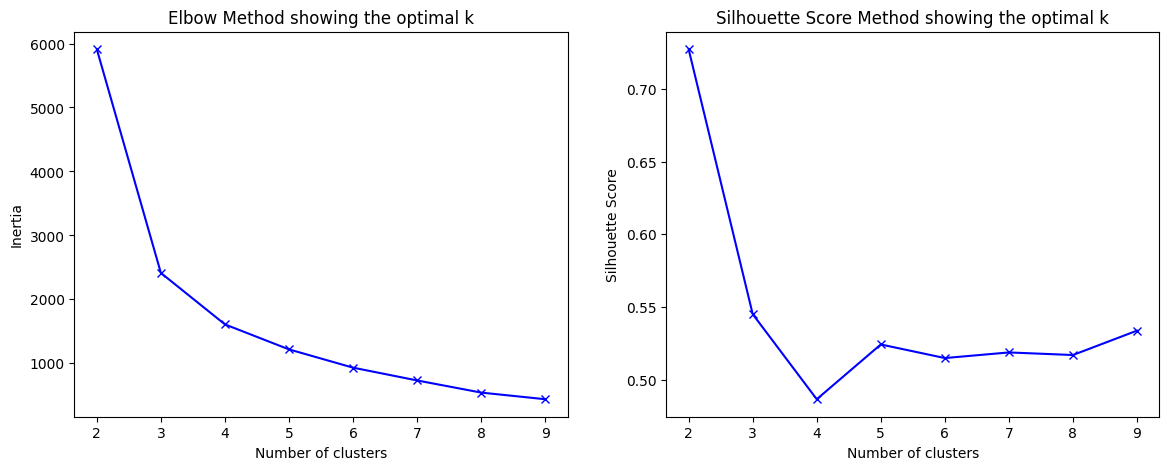

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# データが全て読み込まれ、all_dataに格納されているとします
# 大規模データセットから無作為抽出でサンプリング（例: 5000サンプル）
sampled_data = all_data[np.random.choice(all_data.shape[0], 5000, replace=False), :]

# 標準化を再度行う
scaler = StandardScaler()
sampled_data_scaled = scaler.fit_transform(sampled_data)

# クラスタリングのための最適なクラスタ数を探す
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(sampled_data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sampled_data_scaled, kmeans.labels_))

plt.figure(figsize=(14, 5))

# エルボープロット
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method showing the optimal k')

# シルエットスコアプロット
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method showing the optimal k')

plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cluster labels: [2 2 2 ... 4 4 4]


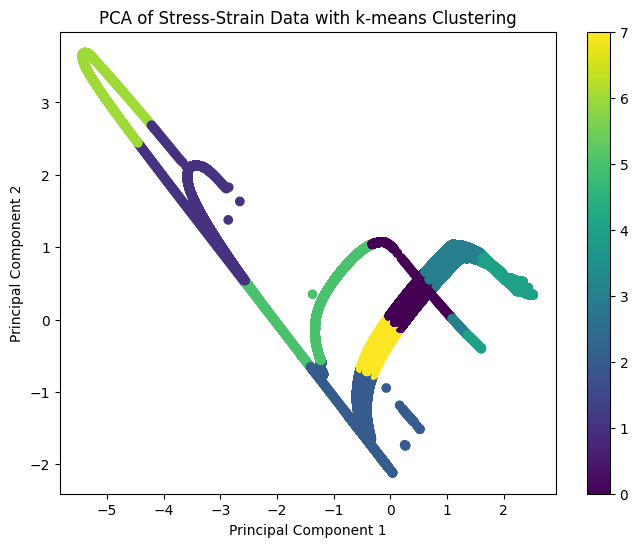

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Google Drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

# データフォルダのパス
data_folder = '/content/drive/MyDrive/clustering'

# データを格納するリスト
data_list = []

# データの読み込み
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_folder, filename)
        df = pd.read_csv(filepath)

        # Nominal strain を横軸、Nominal stress を縦軸とする波形データを生成
        # 必要であれば適切に前処理（例: 補間、ノイズ除去）を行う
        strain_stress_data = np.array(list(zip(df['Nominal strain'], df['Nominal stress'])))
        data_list.append(strain_stress_data)

# すべてのデータを統合
all_data = np.vstack(data_list)

# データの標準化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_data)

# クラスタ数4でk-meansを実行
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
labels = kmeans.fit_predict(data_scaled)

# 結果の確認
print(f"Cluster labels: {labels}")

# クラスタの可視化（2次元の主成分分析を通じて）
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Stress-Strain Data with k-means Clustering')
plt.colorbar()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


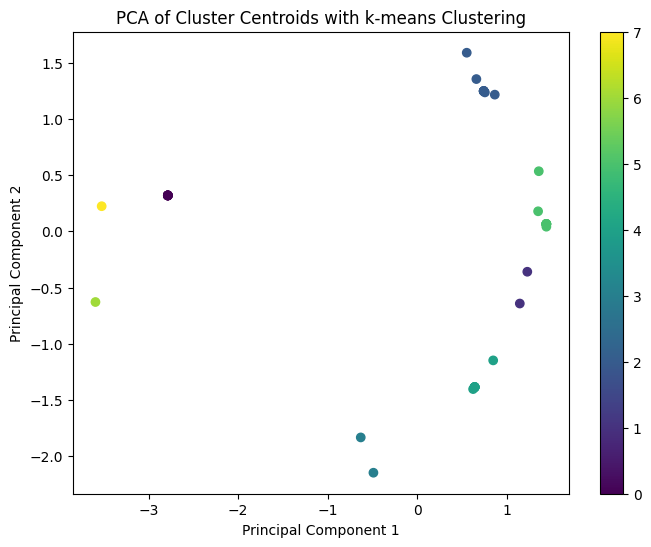

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Google Drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

# データフォルダのパス
data_folder = '/content/drive/MyDrive/clustering'

# 各ファイルのクラスタの重心を格納するリスト
centroids_list = []

# データの読み込みとファイルごとのクラスタリング
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(data_folder, filename)
        df = pd.read_csv(filepath)

        # Nominal strain と Nominal stress の波形データを生成
        strain_stress_data = np.array(list(zip(df['Nominal strain'], df['Nominal stress'])))

        # データの標準化
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(strain_stress_data)

        # ファイル内でのクラスタリング
        kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
        file_labels = kmeans.fit_predict(data_scaled)

        # 各クラスタの重心を取得
        centroids = kmeans.cluster_centers_
        centroids_list.append(centroids)  # 各ファイルのクラスタ重心をリストに追加

# すべてのクラスタ重心を統合し、再クラスタリング
all_centroids = np.vstack(centroids_list)

# 再クラスタリングでクラスタ数を指定
final_kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
final_labels = final_kmeans.fit_predict(all_centroids)

# クラスタの可視化（PCAを用いて2次元に削減）
pca = PCA(n_components=2)
reduced_centroids = pca.fit_transform(all_centroids)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c=final_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Cluster Centroids with k-means Clustering')
plt.colorbar()
plt.show()


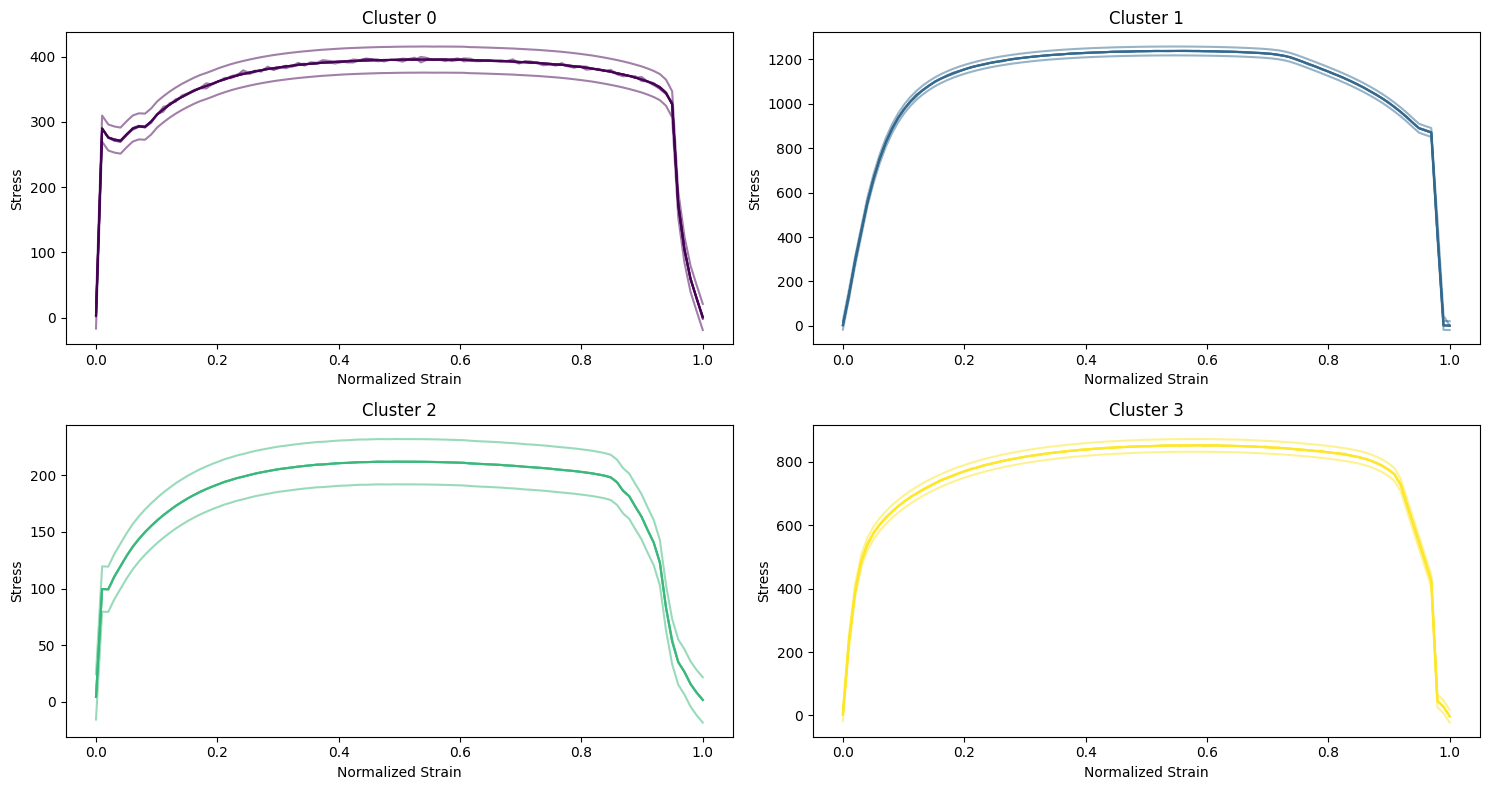


Cluster 0 files:
  - F-P.csv
  - F-P_noised2.csv
  - F-P_stress_decrease_augmented20.csv
  - F-P_stress_increase_augmented20.csv
  - F-P_time_augmented0.1.csv
  - F-P_time_Lengthened0.1.csv
  - F-P_strain_augmented00001.csv
  - F-P_time_shortened0.1.csv
  - F_noised2.csv

Cluster 1 files:
  - M.csv
  - M_time_Lengthened0.1.csv
  - M_noised2.csv
  - M_stress_increase_augmented20.csv
  - M_strain_augmented00001.csv
  - M_time_augmented0.1.csv
  - M_stress_decrease_augmented20.csv
  - M_time_shortened0.1.csv

Cluster 2 files:
  - F_time_augmented0.1.csv
  - F_time_shortened0.1.csv
  - F_stress_increase_augmented20.csv
  - F_stress_decrease_augmented20.csv
  - F_time_Lengthened0.1.csv
  - F_strain_augmented00001.csv
  - F.csv

Cluster 3 files:
  - B.csv
  - B_noised2.csv
  - B_time_Lengthened0.1.csv
  - B_stress_increase_augmented20.csv
  - B_stress_decrease_augmented20.csv
  - B_strain_augmented00001.csv
  - B_time_augmented0.1.csv
  - B_time_shortened0.1.csv


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    """波形データを等間隔にリサンプリングする"""
    # 元のデータポイント
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    # 補間関数の作成
    f = interp1d(x, y, kind='linear')

    # 新しい等間隔のx座標を生成
    x_new = np.linspace(min(x), max(x), num_points)

    # 補間された y 座標を取得
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    """すべての波形データを読み込み、前処理を行う"""
    processed_data = []
    filenames = []

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)

            # 波形データの前処理
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)

    return np.array(processed_data), filenames

def plot_clusters(data, labels, filenames):
    """クラスタリング結果を可視化"""
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(2, (n_clusters + 1) // 2, figsize=(15, 8))
    axes = axes.ravel()

    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_data = data[labels == i]

        # 各クラスタの波形を描画
        for wave in cluster_data:
            axes[i].plot(np.linspace(0, 1, len(wave)), wave, alpha=0.5, color=colors[i])

        axes[i].set_title(f'Cluster {i}')
        axes[i].set_xlabel('Normalized Strain')
        axes[i].set_ylabel('Stress')

    plt.tight_layout()
    plt.show()

    # クラスタごとのファイル名を表示
    for i in range(n_clusters):
        print(f"\nCluster {i} files:")
        cluster_files = [filenames[j] for j in range(len(labels)) if labels[j] == i]
        for file in cluster_files:
            print(f"  - {file}")

def main():
    # データフォルダのパス
    data_folder = '/content/drive/MyDrive/clustering'

    # データの読み込みと前処理
    processed_data, filenames = load_and_process_data(data_folder)

    # データの標準化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)

    # クラスタリングの実行
    n_clusters = 4  # クラスタ数は適宜調整
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

    # 結果の可視化
    plot_clusters(processed_data, labels, filenames)

    return processed_data, labels, filenames

# メイン処理の実行
processed_data, labels, filenames = main()

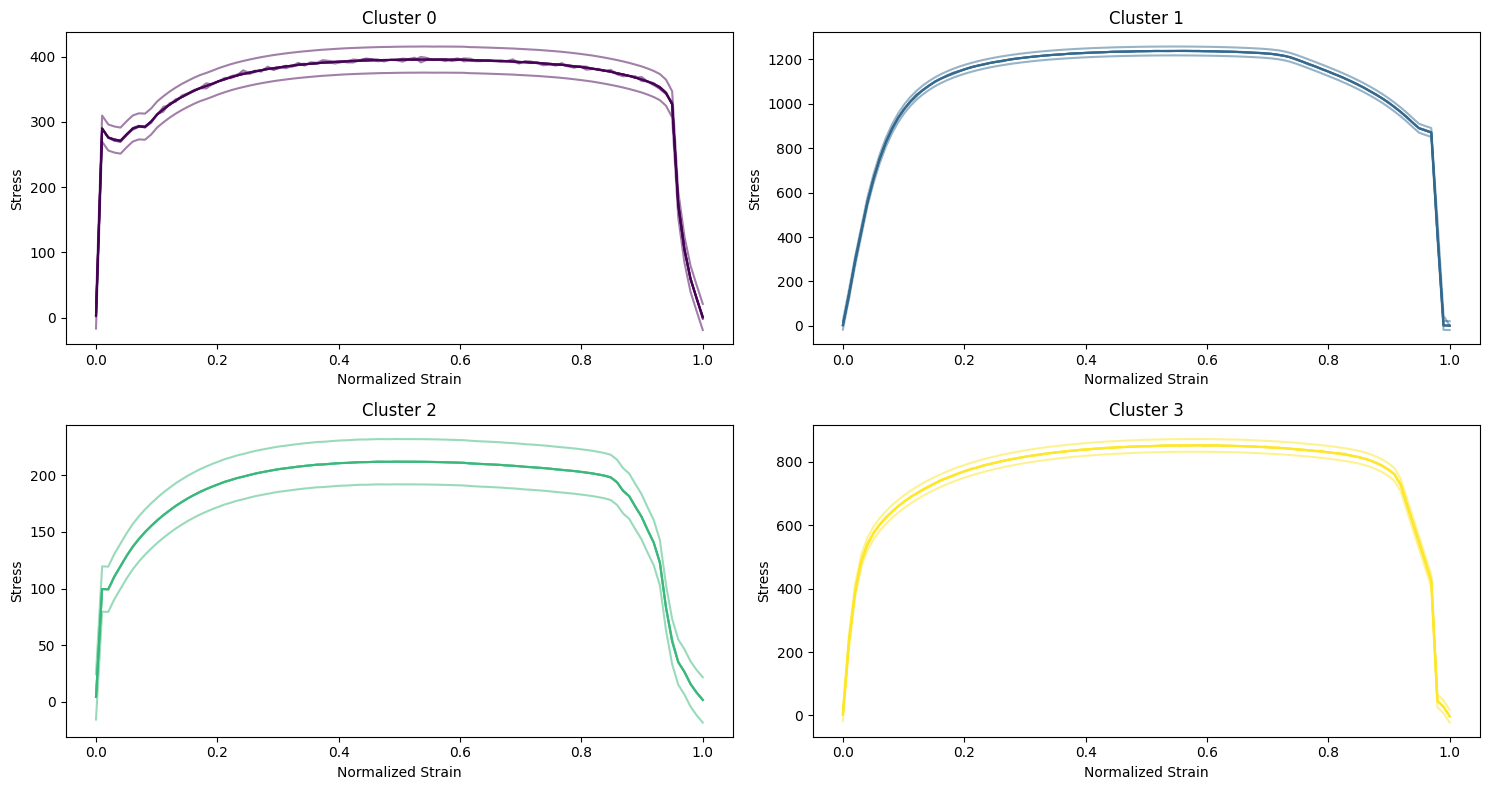


Cluster 0 files:
  - F-P.csv
  - F-P_noised2.csv
  - F-P_stress_decrease_augmented20.csv
  - F-P_stress_increase_augmented20.csv
  - F-P_time_augmented0.1.csv
  - F-P_time_Lengthened0.1.csv
  - F-P_strain_augmented00001.csv
  - F-P_time_shortened0.1.csv
  - F_noised2.csv

Cluster 1 files:
  - M.csv
  - M_time_Lengthened0.1.csv
  - M_noised2.csv
  - M_stress_increase_augmented20.csv
  - M_strain_augmented00001.csv
  - M_time_augmented0.1.csv
  - M_stress_decrease_augmented20.csv
  - M_time_shortened0.1.csv

Cluster 2 files:
  - F_time_augmented0.1.csv
  - F_time_shortened0.1.csv
  - F_stress_increase_augmented20.csv
  - F_stress_decrease_augmented20.csv
  - F_time_Lengthened0.1.csv
  - F_strain_augmented00001.csv
  - F.csv

Cluster 3 files:
  - B.csv
  - B_noised2.csv
  - B_time_Lengthened0.1.csv
  - B_stress_increase_augmented20.csv
  - B_stress_decrease_augmented20.csv
  - B_strain_augmented00001.csv
  - B_time_augmented0.1.csv
  - B_time_shortened0.1.csv
Cluster 0 contribution: 28.1

In [ ]:
def main():
    # データフォルダのパス
    data_folder = '/content/drive/MyDrive/clustering'

    # データの読み込みと前処理
    processed_data, filenames = load_and_process_data(data_folder)

    # データの標準化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)

    # クラスタリングの実行
    n_clusters = 4  # クラスタ数は適宜調整
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

    # 結果の可視化
    plot_clusters(processed_data, labels, filenames)

    # クラスタごとの寄与率を計算して表示
    total_samples = len(labels)
    for i in range(n_clusters):
        cluster_size = np.sum(labels == i)
        contribution_ratio = cluster_size / total_samples
        print(f"Cluster {i} contribution: {contribution_ratio:.2%}")

    return processed_data, labels, filenames

# メイン処理の実行
processed_data, labels, filenames = main()

Cluster Centroids (Unscaled):
Cluster 0: [  4.238553    99.59060931  99.32303776 110.59030072 119.74104363
 128.8938745  136.96631131 143.79446186 149.88099772 155.28970373
 160.29247116 164.87407263 168.99755431 172.98188554 176.4589078
 179.75837934 182.69701432 185.45620876 187.89896097 190.1603872
 192.22184574 194.28403261 195.89075497 197.57799036 198.84819525
 200.27308779 201.59803502 202.70663825 203.71082658 204.7152839
 205.62384108 206.29531518 207.01242328 207.72445466 208.32347761
 208.85997937 209.43803143 209.65826595 210.08509252 210.52297394
 210.87992937 211.03528166 211.37260864 211.6531667  211.69411767
 211.85363388 212.05481324 212.00298097 211.96445355 212.11665547
 212.0294     212.0426     212.02521089 211.98978878 211.9303
 211.84119681 211.71447418 211.57112158 211.40988913 211.25650804
 211.09188857 210.61289048 210.27777486 210.03174238 209.77536649
 209.50930826 209.22892626 208.79611441 208.48254652 208.08960969
 207.56713039 207.26017973 206.84637051 20

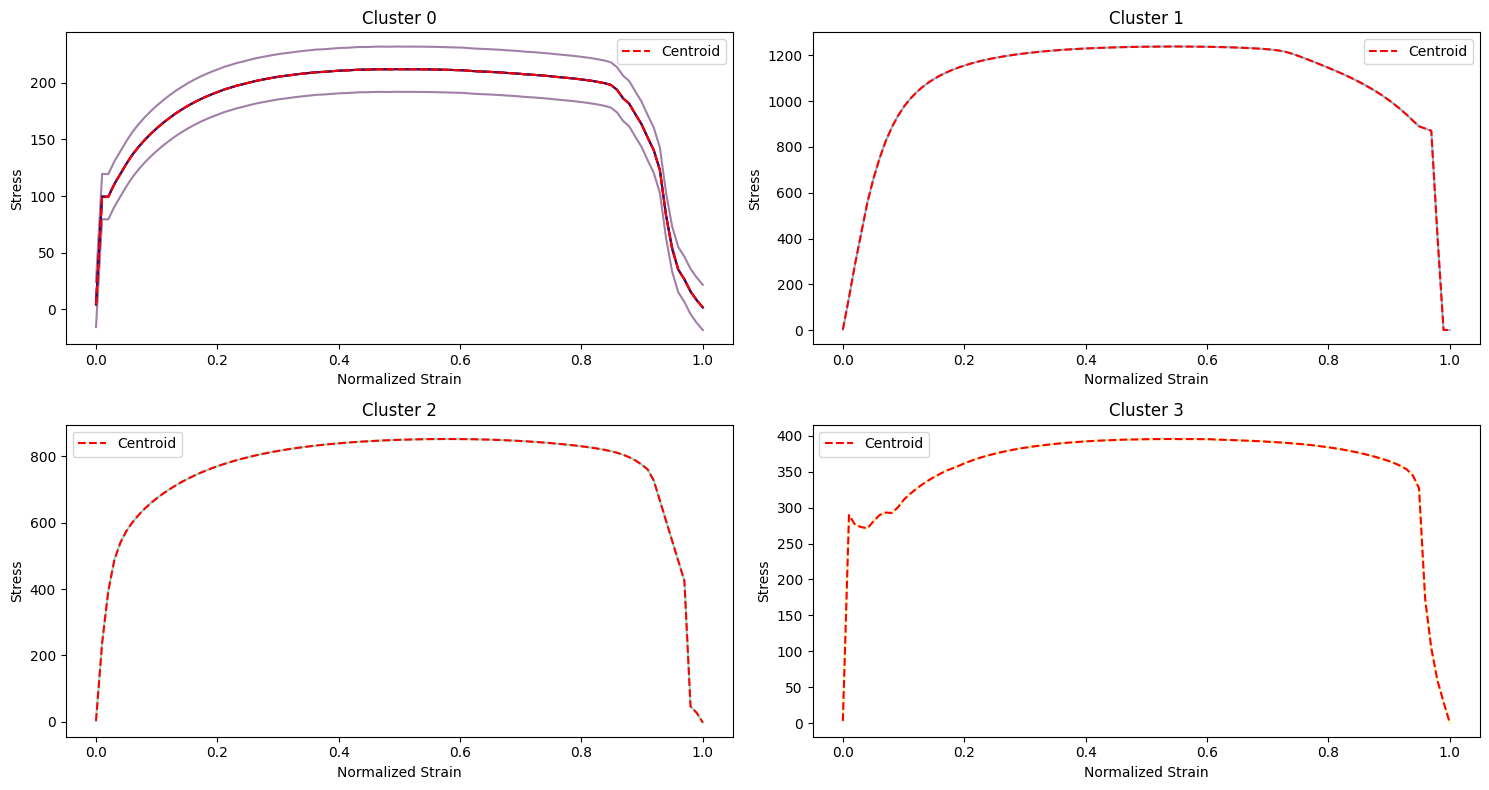


Cluster 0 files:
  - F_time_augmented0.1.csv
  - F_time_shortened0.1.csv
  - F_stress_increase_augmented20.csv
  - F_stress_decrease_augmented20.csv
  - F_time_Lengthened0.1.csv
  - F_strain_augmented00001.csv
  - F.csv

Cluster 1 files:
  - M.csv

Cluster 2 files:
  - B.csv

Cluster 3 files:
  - F-P.csv


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    """波形データを等間隔にリサンプリングする"""
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    """すべての波形データを読み込み、前処理を行う"""
    processed_data = []
    filenames = []

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)

            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)

    return np.array(processed_data), filenames

def plot_clusters(data, labels, filenames, centroids):
    """クラスタリング結果を可視化"""
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(2, (n_clusters + 1) // 2, figsize=(15, 8))
    axes = axes.ravel()

    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_data = data[labels == i]

        for wave in cluster_data:
            axes[i].plot(np.linspace(0, 1, len(wave)), wave, alpha=0.5, color=colors[i])

        # クラスタ中心をプロット
        axes[i].plot(np.linspace(0, 1, len(centroids[i])), centroids[i], color='red', linestyle='--', label='Centroid')

        axes[i].set_title(f'Cluster {i}')
        axes[i].set_xlabel('Normalized Strain')
        axes[i].set_ylabel('Stress')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

    for i in range(n_clusters):
        print(f"\nCluster {i} files:")
        cluster_files = [filenames[j] for j in range(len(labels)) if labels[j] == i]
        for file in cluster_files:
            print(f"  - {file}")

def main():
    data_folder = '/content/drive/MyDrive/clustering'

    processed_data, filenames = load_and_process_data(data_folder)

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)

    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

    centroids = kmeans.cluster_centers_

    # クラスタ中心をスケーリングなしで取得する
    centroids_unscaled = scaler.inverse_transform(centroids)

    # クラスタ中心とラベルを表示
    print("Cluster Centroids (Unscaled):")
    for i, centroid in enumerate(centroids_unscaled):
        print(f"Cluster {i}: {centroid}")

    plot_clusters(processed_data, labels, filenames, centroids_unscaled)

    return processed_data, labels, filenames, centroids_unscaled

# メイン処理の実行
processed_data, labels, filenames, centroids_unscaled = main()

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

def apply_pca(processed_data, n_components=4):
    """
    Process the waveforms using PCA to reduce dimensionality.

    Args:
        processed_data (numpy.array): The input waveform data.
        n_components (int): Number of dimensions to reduce to.

    Returns:
        transformed_data (numpy.array): The PCA-transformed data.
        pca_model (sklearn.decomposition.PCA): The fitted PCA model.
    """
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(processed_data)
    return transformed_data, pca

def main():
    data_folder = '/content/drive/MyDrive/clustering'
    processed_data, filenames = load_and_process_data(data_folder)

    # PCAを適用
    pca_transformed_data, pca_model = apply_pca(processed_data, n_components=4)

    print("Transformed data shape:", pca_transformed_data.shape)
    print("Explained variance ratio:", pca_model.explained_variance_ratio_)

    # pca_transformed_dataを用いて、新しい次元で波形を表現します
    for i, filename in enumerate(filenames):
        print(f"File: {filename}, PCA Params: {pca_transformed_data[i]}")

    # 以降のクラスタリングや分析はpca_transformed_dataを使用することができます

# メイン処理の実行
main()

Transformed data shape: (10, 4)
Explained variance ratio: [9.96975149e-01 2.48913066e-03 4.98547058e-04 3.71280790e-05]
File: F_time_augmented0.1.csv, PCA Params: [-1.67444682e+03 -4.35318735e+01 -1.45575143e+01  1.19809147e+00]
File: F_time_shortened0.1.csv, PCA Params: [-1.67444682e+03 -4.35318735e+01 -1.45575143e+01  1.19809147e+00]
File: F_stress_increase_augmented20.csv, PCA Params: [-1480.73521855   -23.11292985     4.21900798    42.50577224]
File: F_stress_decrease_augmented20.csv, PCA Params: [-1868.15841997   -63.9508171    -33.33403653   -40.1095893 ]
File: F_time_Lengthened0.1.csv, PCA Params: [-1.67444682e+03 -4.35318735e+01 -1.45575143e+01  1.19809147e+00]
File: F_strain_augmented00001.csv, PCA Params: [-1.67418545e+03 -4.33069113e+01 -1.30935941e+01  5.00756952e-01]
File: M.csv, PCA Params: [ 7.52844529e+03 -2.48570720e+02  3.66091447e+01 -7.20686878e-01]
File: B.csv, PCA Params: [ 4.13334197e+03  3.24208545e+02 -1.11635213e+02  6.64905627e-01]
File: F-P.csv, PCA Params: 

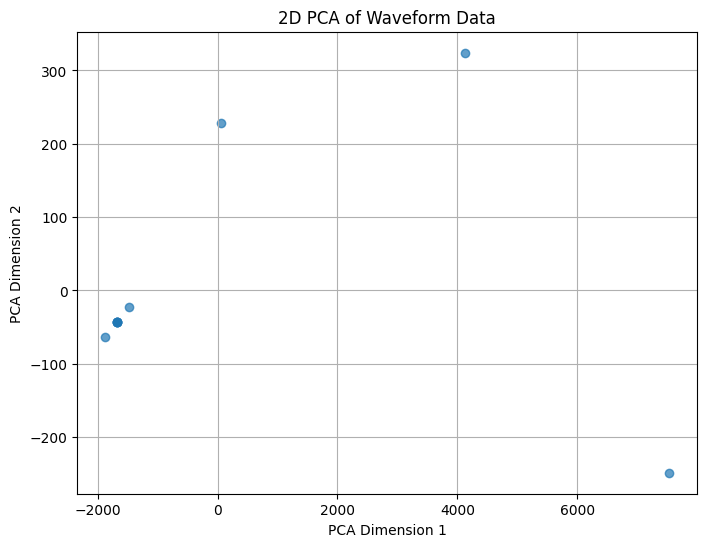

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    processed_data = []

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)

    return np.array(processed_data)

def apply_pca(processed_data):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(processed_data)
    return transformed_data, pca

def plot_2d_map(transformed_data):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    plt.title('2D PCA of Waveform Data')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True)
    plt.show()

def main():
    data_folder = '/content/drive/MyDrive/clustering'
    processed_data = load_and_process_data(data_folder)

    # PCAを適用して2次元へ次元削減
    pca_transformed_data, _ = apply_pca(processed_data)

    # 2次元マップをプロット
    plot_2d_map(pca_transformed_data)

main()

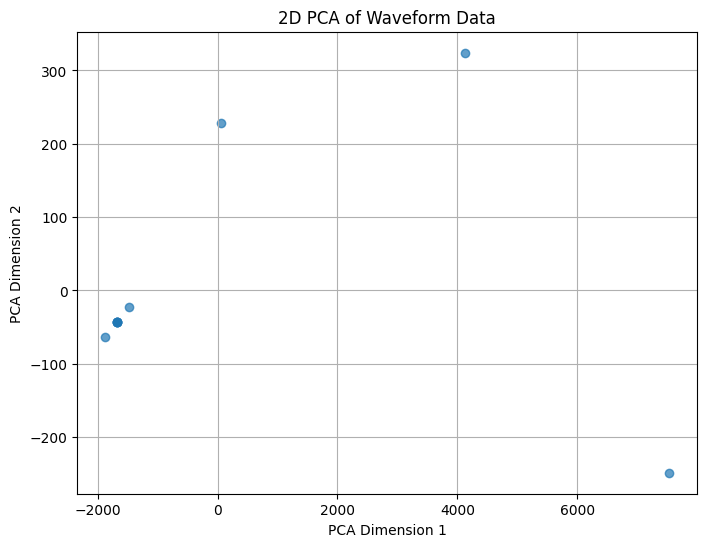

PCA 2D Parameters for Each Data Point:
1. File: F_time_augmented0.1.csv, PCA 2D params: [-1674.44681926   -43.53187348]
2. File: F_time_shortened0.1.csv, PCA 2D params: [-1674.44681926   -43.53187348]
3. File: F_stress_increase_augmented20.csv, PCA 2D params: [-1480.73521855   -23.11292985]
4. File: F_stress_decrease_augmented20.csv, PCA 2D params: [-1868.15841997   -63.9508171 ]
5. File: F_time_Lengthened0.1.csv, PCA 2D params: [-1674.44681926   -43.53187348]
6. File: F_strain_augmented00001.csv, PCA 2D params: [-1674.18545056   -43.30691126]
7. File: M.csv, PCA 2D params: [7528.44528615 -248.57072029]
8. File: B.csv, PCA 2D params: [4133.34197109  324.20854527]
9. File: F-P.csv, PCA 2D params: [ 59.07910886 228.86032713]
10. File: F.csv, PCA 2D params: [-1674.44681926   -43.53187348]


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    processed_data = []
    filenames = []  # ファイル名を保持

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)

    return np.array(processed_data), filenames

def apply_pca(processed_data):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(processed_data)
    return transformed_data, pca

def plot_2d_map(transformed_data):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    plt.title('2D PCA of Waveform Data')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True)
    plt.show()

def main():
    data_folder = '/content/drive/MyDrive/clustering'
    processed_data, filenames = load_and_process_data(data_folder)

    # PCAを適用して2次元へ次元削減
    pca_transformed_data, _ = apply_pca(processed_data)

    # 2次元マップをプロット
    plot_2d_map(pca_transformed_data)

    # 各データの2次元パラメータを出力
    print("PCA 2D Parameters for Each Data Point:")
    for i, (filename, params) in enumerate(zip(filenames, pca_transformed_data)):
        print(f"{i+1}. File: {filename}, PCA 2D params: {params}")

main()

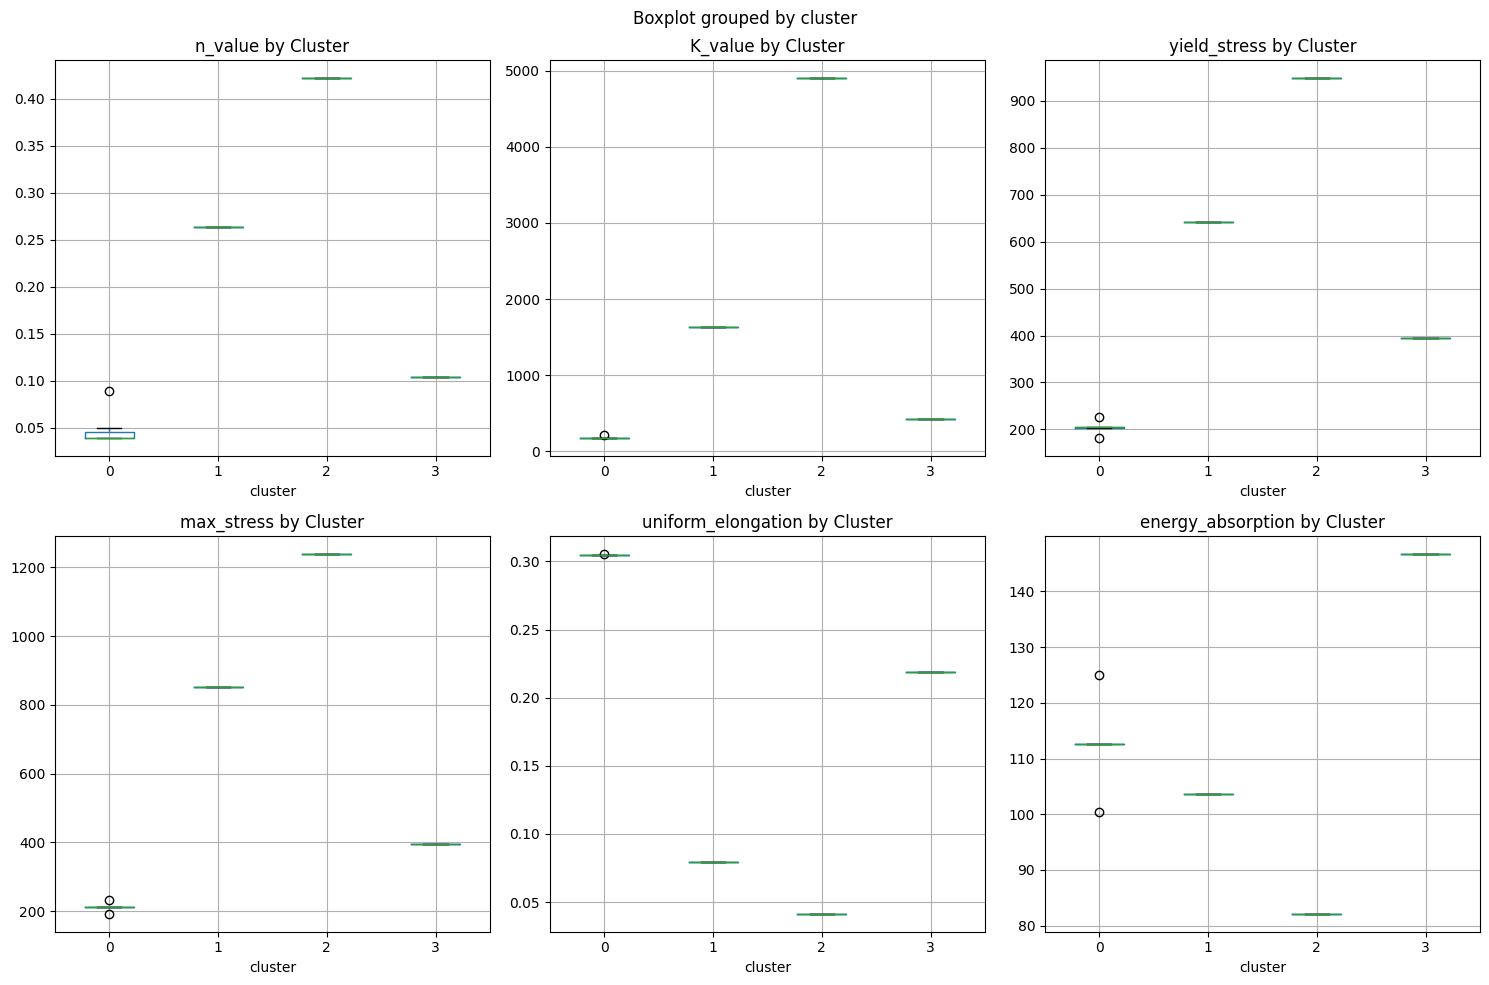

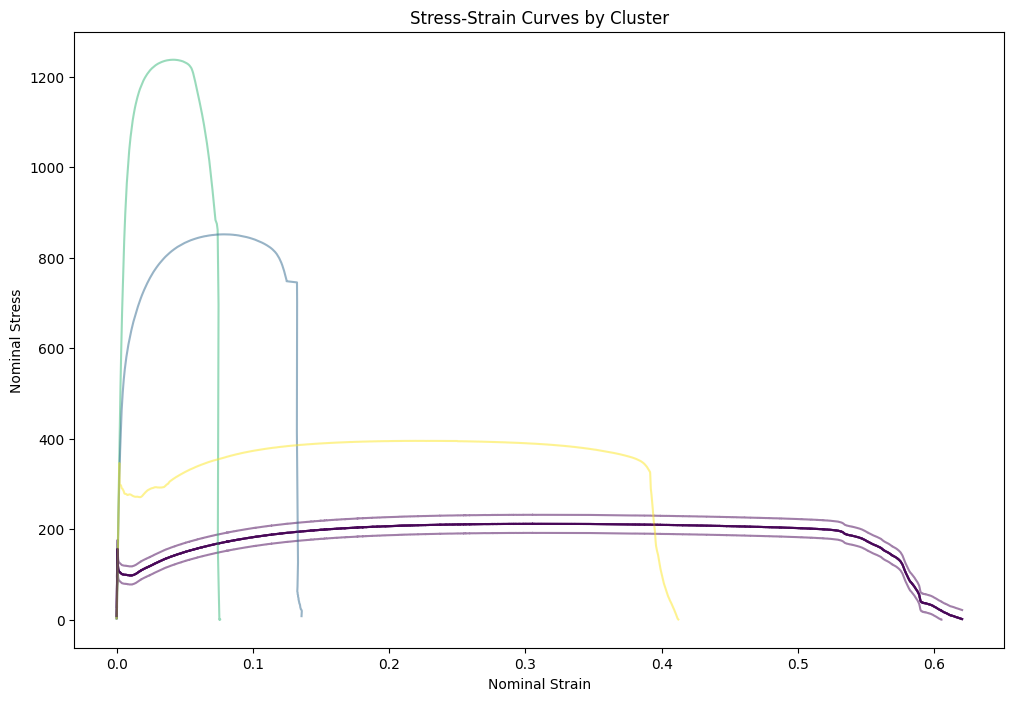

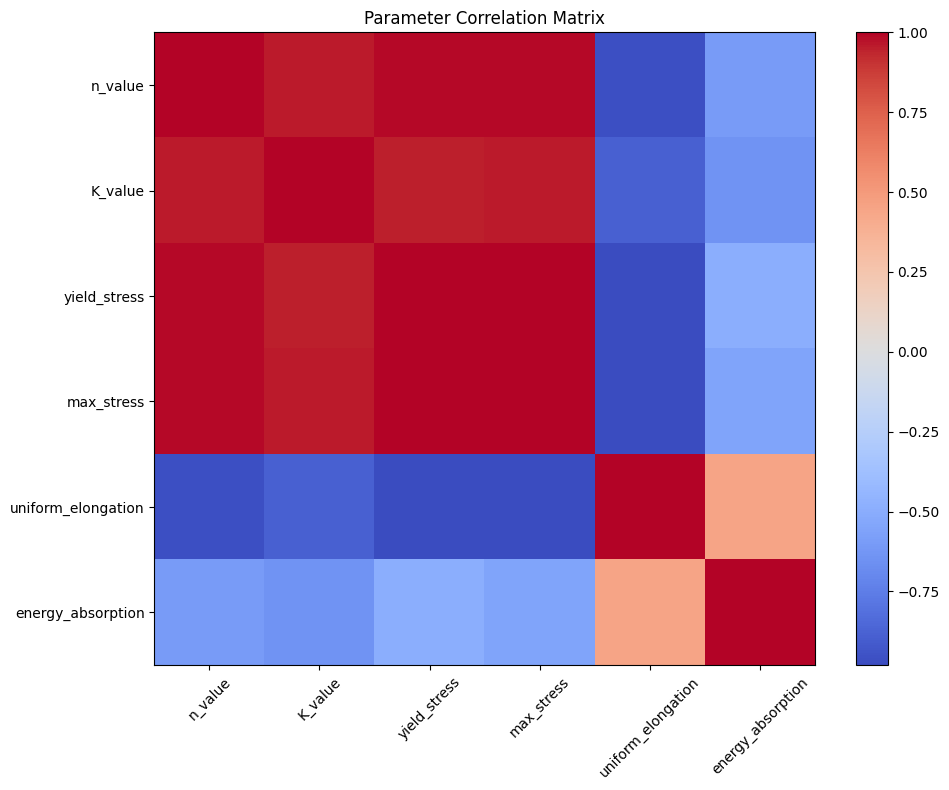

Results exported to material_parameters.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d
from scipy import stats
import os
import warnings
warnings.filterwarnings('ignore')  # 警告を抑制

class StressStrainAnalyzer:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.processed_data = []
        self.filenames = []
        self.parameters = pd.DataFrame()

    def load_and_process_data(self):
        """データの読み込みと前処理"""
        for filename in os.listdir(self.data_folder):
            if filename.endswith('.csv'):
                filepath = os.path.join(self.data_folder, filename)
                df = pd.read_csv(filepath)

                # 負の値やゼロの除去
                df = df[
                    (df['Nominal strain'] > 0) &
                    (df['Nominal stress'] > 0)
                ].copy()

                # データが十分にある場合のみ処理
                if len(df) > 10:  # 最低10点以上のデータがある場合
                    self.processed_data.append(df)
                    self.filenames.append(filename)

    def calculate_hardening_parameters(self):
        """各曲線の加工硬化パラメータを計算"""
        parameters_list = []

        for i, df in enumerate(self.processed_data):
            try:
                strain = df['Nominal strain'].values
                stress = df['Nominal stress'].values

                # 対数変換
                log_strain = np.log10(strain)
                log_stress = np.log10(stress)

                # 異常値の除去
                mask = np.isfinite(log_strain) & np.isfinite(log_stress)
                log_strain = log_strain[mask]
                log_stress = log_stress[mask]

                if len(log_strain) < 2:  # データが不十分な場合はスキップ
                    continue

                # 加工硬化指数(n値)の計算
                slope, intercept, r_value, p_value, std_err = stats.linregress(log_strain, log_stress)
                n_value = slope

                # 強度係数(K値)の計算
                K = 10**intercept

                # 降伏応力の近似値
                yield_stress = self._calculate_yield_stress(strain, stress)

                # その他のパラメータ計算
                max_stress = np.max(stress)
                max_stress_idx = np.argmax(stress)
                uniform_elongation = strain[max_stress_idx]
                energy_absorption = np.trapz(stress, strain)

                # 計算結果の保存
                params = {
                    'filename': self.filenames[i],
                    'n_value': n_value,
                    'K_value': K,
                    'yield_stress': yield_stress if yield_stress is not None else np.nan,
                    'max_stress': max_stress,
                    'uniform_elongation': uniform_elongation,
                    'energy_absorption': energy_absorption,
                    'r_squared': r_value**2
                }

                # NaNチェック
                if all(np.isfinite(list(params.values())[1:])):  # filenameを除く
                    parameters_list.append(params)

            except Exception as e:
                print(f"Error processing file {self.filenames[i]}: {str(e)}")
                continue

        self.parameters = pd.DataFrame(parameters_list)
        return self.parameters

    def _calculate_yield_stress(self, strain, stress, offset=0.002):
        """0.2%オフセット法による降伏応力の計算"""
        try:
            # ヤング率の推定（初期の傾き）
            young_idx = max(int(len(strain) * 0.1), 2)  # 最低2点は使用
            E = np.polyfit(strain[:young_idx], stress[:young_idx], 1)[0]

            # オフセット線の計算
            offset_line = E * (strain - offset)

            # 交点の探索
            diff = stress - offset_line
            cross_idx = np.where(np.diff(np.signbit(diff)))[0]

            if len(cross_idx) > 0:
                return stress[cross_idx[0]]

        except Exception as e:
            print(f"Error in yield stress calculation: {str(e)}")

        return np.nan

    def cluster_by_parameters(self, n_clusters=4):
        """パラメータに基づくクラスタリング"""
        if len(self.parameters) == 0:
            print("No valid parameters to cluster")
            return self.parameters

        # 使用するパラメータの選択
        features = ['n_value', 'K_value', 'yield_stress', 'max_stress',
                   'uniform_elongation', 'energy_absorption']

        # NaNを含む行を除外
        valid_params = self.parameters.dropna(subset=features)

        if len(valid_params) < n_clusters:
            print(f"Not enough valid data points ({len(valid_params)}) for {n_clusters} clusters")
            return self.parameters

        X = valid_params[features].values

        # データの標準化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # クラスタリング
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        valid_params['cluster'] = kmeans.fit_predict(X_scaled)

        # 元のデータフレームにクラスタ情報を結合
        self.parameters = self.parameters.merge(
            valid_params[['filename', 'cluster']],
            on='filename',
            how='left'
        )

        return self.parameters

    def visualize_results(self):
        """結果の可視化"""
        if len(self.parameters) == 0:
            print("No data to visualize")
            return

        # 有効なデータのみを使用
        valid_params = self.parameters.dropna(subset=['cluster'])

        if len(valid_params) == 0:
            print("No valid clusters to visualize")
            return

        # クラスタごとの特性パラメータの箱ひげ図
        features = ['n_value', 'K_value', 'yield_stress',
                   'max_stress', 'uniform_elongation', 'energy_absorption']

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, feature in enumerate(features):
            valid_params.boxplot(column=feature, by='cluster', ax=axes[i])
            axes[i].set_title(f'{feature} by Cluster')

        plt.tight_layout()
        plt.show()

        # クラスタごとの応力-ひずみ曲線
        plt.figure(figsize=(12, 8))
        colors = plt.cm.viridis(np.linspace(0, 1, len(valid_params['cluster'].unique())))

        for i, (_, row) in enumerate(valid_params.iterrows()):
            df = self.processed_data[i]
            plt.plot(df['Nominal strain'], df['Nominal stress'],
                    color=colors[int(row['cluster'])], alpha=0.5)

        plt.xlabel('Nominal Strain')
        plt.ylabel('Nominal Stress')
        plt.title('Stress-Strain Curves by Cluster')
        plt.show()

        # パラメータの相関行列
        correlation = valid_params[features].corr()
        plt.figure(figsize=(10, 8))
        plt.imshow(correlation, cmap='coolwarm', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(features)), features, rotation=45)
        plt.yticks(range(len(features)), features)
        plt.title('Parameter Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def export_results(self, output_path):
        """結果をCSVファイルとして出力"""
        if len(self.parameters) > 0:
            self.parameters.to_csv(output_path, index=False)
            print(f"Results exported to {output_path}")
        else:
            print("No results to export")

def main():
    # データフォルダのパス
    data_folder = '/content/drive/MyDrive/clustering'

    # 解析の実行
    analyzer = StressStrainAnalyzer(data_folder)
    analyzer.load_and_process_data()
    analyzer.calculate_hardening_parameters()
    analyzer.cluster_by_parameters()
    analyzer.visualize_results()

    # 結果の出力
    analyzer.export_results('material_parameters.csv')

if __name__ == '__main__':
    main()

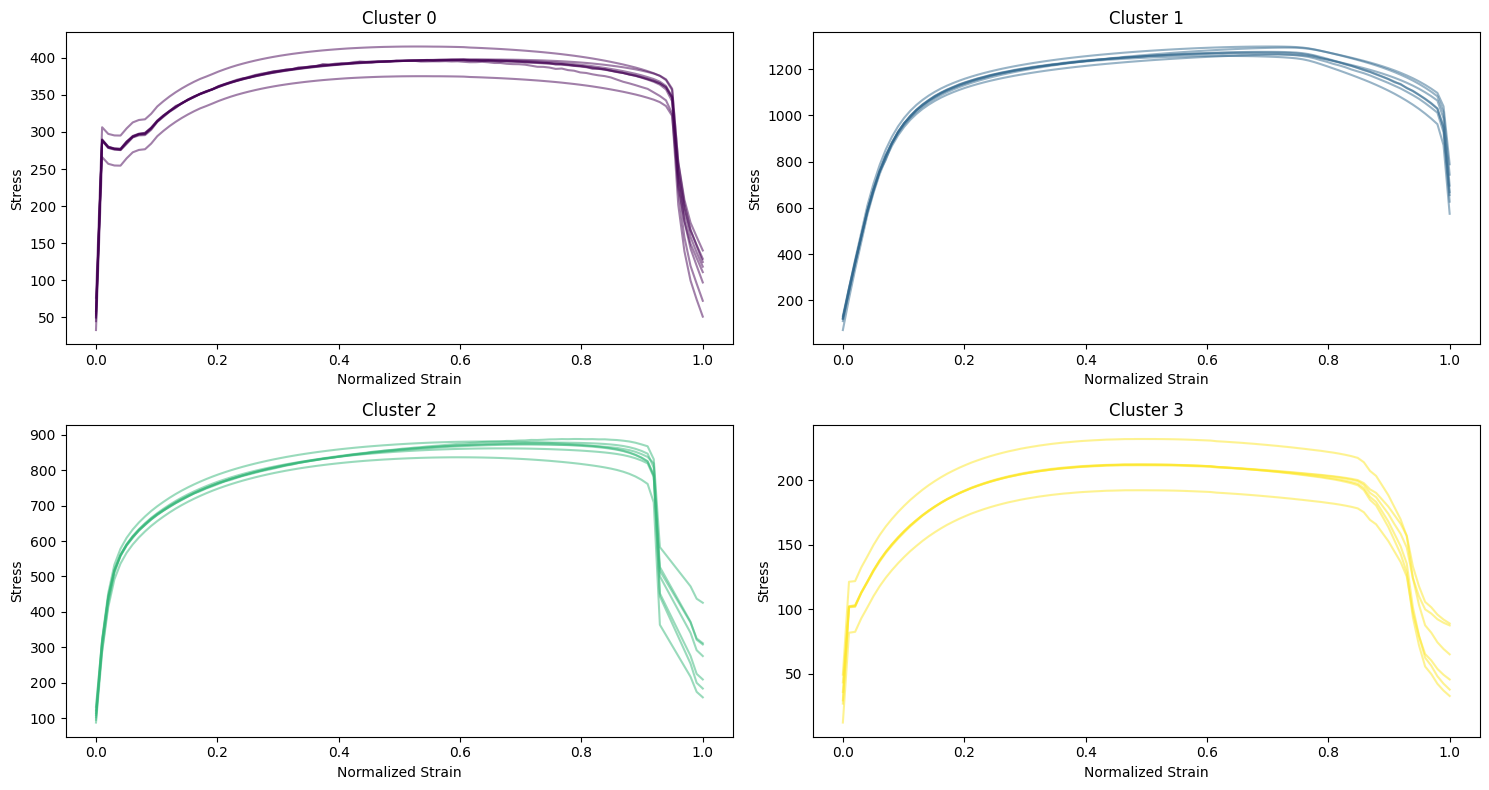


Cluster 0 files:
  - F-P_forecast.csv
  - F-P_noised2_forecast.csv
  - F-P_stress_decrease_augmented20_forecast.csv
  - F-P_stress_increase_augmented20_forecast.csv
  - F-P_time_augmented0_forecast.csv
  - F-P_time_Lengthened0_forecast.csv
  - F-P_strain_augmented00001_forecast.csv
  - F_noised2_forecast.csv

Cluster 1 files:
  - M_forecast.csv
  - M_time_Lengthened0_forecast.csv
  - M_noised2_forecast.csv
  - M_stress_increase_augmented20_forecast.csv
  - M_strain_augmented00001_forecast.csv
  - M_time_augmented0_forecast.csv
  - M_stress_decrease_augmented20_forecast.csv

Cluster 2 files:
  - B_forecast.csv
  - B_noised2_forecast.csv
  - B_time_Lengthened0_forecast.csv
  - B_stress_increase_augmented20_forecast.csv
  - B_stress_decrease_augmented20_forecast.csv
  - B_strain_augmented00001_forecast.csv
  - B_time_augmented0_forecast.csv

Cluster 3 files:
  - F_time_augmented0_forecast.csv
  - F_stress_increase_augmented20_forecast.csv
  - F_stress_decrease_augmented20_forecast.csv
  

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    """波形データを等間隔にリサンプリングする"""
    # 元のデータポイント
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    # 補間関数の作成
    f = interp1d(x, y, kind='linear')

    # 新しい等間隔のx座標を生成
    x_new = np.linspace(min(x), max(x), num_points)

    # 補間された y 座標を取得
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    """すべての波形データを読み込み、前処理を行う"""
    processed_data = []
    filenames = []

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)

            # NaN値の処理
            df = df.dropna()

            # 波形データの前処理
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)

    return np.array(processed_data), filenames

def plot_clusters(data, labels, filenames):
    """クラスタリング結果を可視化"""
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(2, (n_clusters + 1) // 2, figsize=(15, 8))
    axes = axes.ravel()

    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_data = data[labels == i]

        # 各クラスタの波形を描画
        for wave in cluster_data:
            axes[i].plot(np.linspace(0, 1, len(wave)), wave, alpha=0.5, color=colors[i])

        axes[i].set_title(f'Cluster {i}')
        axes[i].set_xlabel('Normalized Strain')
        axes[i].set_ylabel('Stress')

    plt.tight_layout()
    plt.show()

    # クラスタごとのファイル名を表示
    for i in range(n_clusters):
        print(f"\nCluster {i} files:")
        cluster_files = [filenames[j] for j in range(len(labels)) if labels[j] == i]
        for file in cluster_files:
            print(f"  - {file}")

def main():
    # データフォルダのパス
    data_folder = '/content/drive/MyDrive/forecast_LSTM'

    # データの読み込みと前処理
    processed_data, filenames = load_and_process_data(data_folder)

    # データの標準化
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)

    # クラスタリングの実行
    n_clusters = 4  # クラスタ数は適宜調整
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)

    # 結果の可視化
    plot_clusters(processed_data, labels, filenames)

    return processed_data, labels, filenames

# メイン処理の実行
processed_data, labels, filenames = main()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values

    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)

    return y_new

def load_and_process_data(data_folder, num_points=100):
    processed_data = []

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)

    return np.array(processed_data)

def apply_pca(processed_data):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(processed_data)
    return transformed_data, pca

def plot_2d_map(transformed_data):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    plt.title('2D PCA of Waveform Data')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True)
    plt.show()

def main():
    data_folder = '/content/drive/MyDrive/forecast_LSTM'
    processed_data = load_and_process_data(data_folder)

    # PCAを適用して2次元へ次元削減
    pca_transformed_data, _ = apply_pca(processed_data)

    # 2次元マップをプロット
    plot_2d_map(pca_transformed_data)

main()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
import os

def load_and_process_data(data_folder, num_points=100):
    processed_data = []
    filenames = []

    # デバッグ用にロードしたファイルを表示
    print("Reading files from:", data_folder)

    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            print("Loading:", filepath)  # デバッグ用
            df = pd.read_csv(filepath)

            # データが空でないか確認
            if df.empty:
                print("Warning: DataFrame is empty for file:", filename)
                continue

            # 必要なカラムが存在するか確認
            if 'Nominal strain' not in df.columns or 'Nominal stress' not in df.columns:
                print("Warning: Required columns are missing in file:", filename)
                continue

            df = df.dropna()
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)

    # 処理されたデータの数を表示
    print("Number of processed files:", len(filenames))

    return np.array(processed_data), filenames

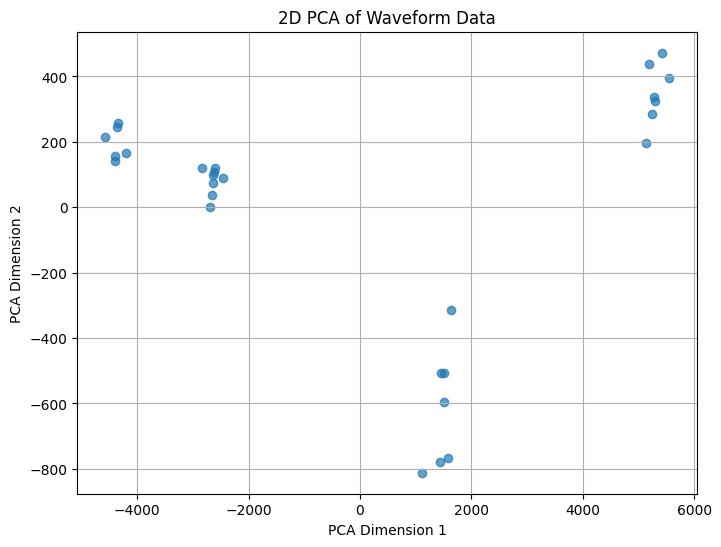

PCA 2D Parameters for Each Data Point:
1. File: F_time_augmented0_forecast.csv, PCA 2D params: [-4351.77750905   256.5072063 ]
2. File: F_stress_increase_augmented20_forecast.csv, PCA 2D params: [-4193.20573832   164.4774301 ]
3. File: F_stress_decrease_augmented20_forecast.csv, PCA 2D params: [-4568.29991591   215.62699371]
4. File: F_time_Lengthened0_forecast.csv, PCA 2D params: [-4400.22880466   142.54775601]
5. File: F_strain_augmented00001_forecast.csv, PCA 2D params: [-4363.17497358   245.03231553]
6. File: M_forecast.csv, PCA 2D params: [5135.23435381  195.72248359]
7. File: B_forecast.csv, PCA 2D params: [1464.81254312 -506.35723809]
8. File: F-P_forecast.csv, PCA 2D params: [-2607.82789396   119.54247932]
9. File: F_forecast.csv, PCA 2D params: [-4392.43398682   157.52920844]
10. File: F-P_noised2_forecast.csv, PCA 2D params: [-2624.33475707   108.76534815]
11. File: F-P_stress_decrease_augmented20_forecast.csv, PCA 2D params: [-2838.64407923   120.40642829]
12. File: F-P_stre

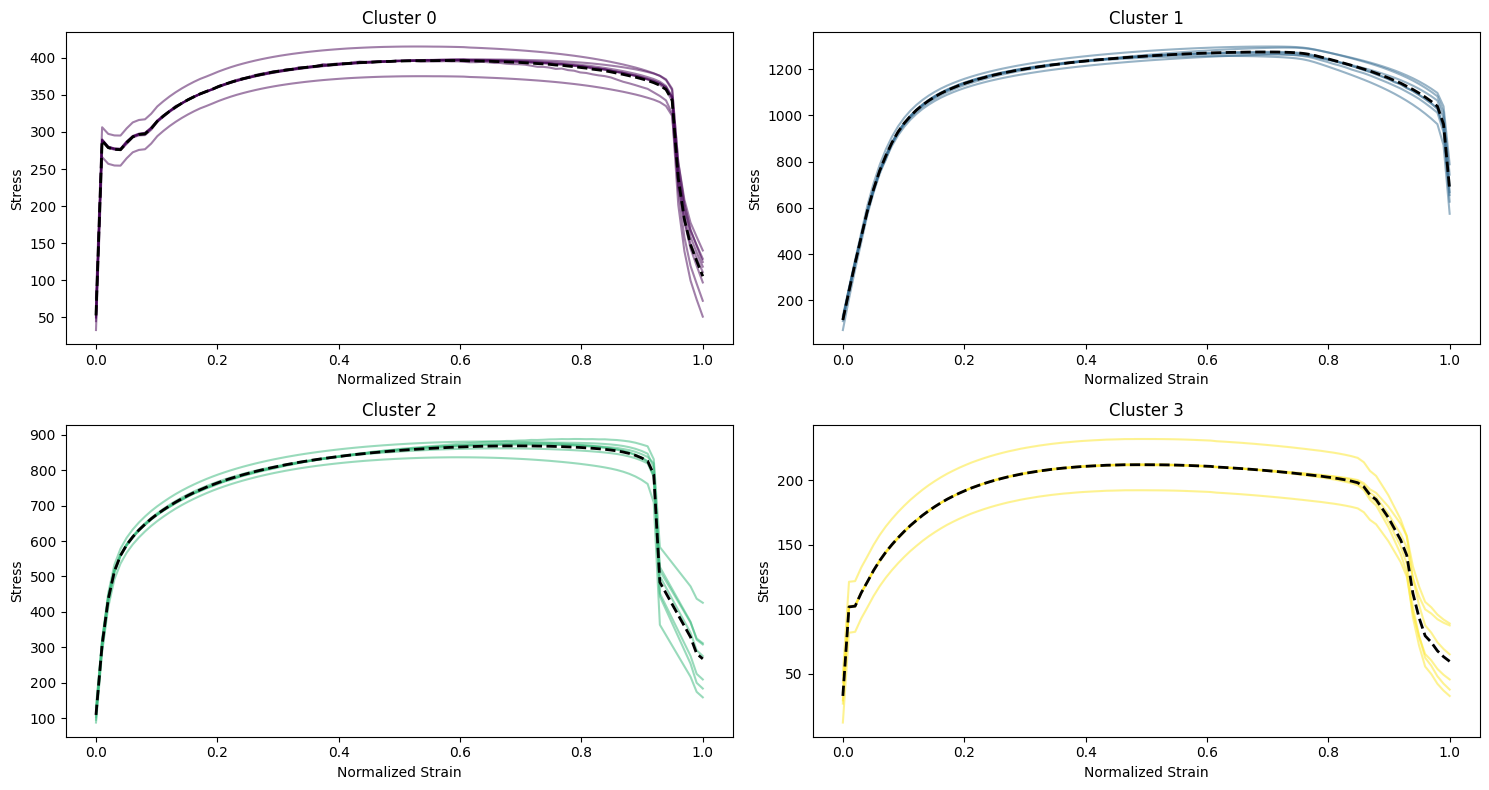


Cluster 0 files:
  - F-P_forecast.csv
  - F-P_noised2_forecast.csv
  - F-P_stress_decrease_augmented20_forecast.csv
  - F-P_stress_increase_augmented20_forecast.csv
  - F-P_time_augmented0_forecast.csv
  - F-P_time_Lengthened0_forecast.csv
  - F-P_strain_augmented00001_forecast.csv
  - F_noised2_forecast.csv

Cluster 1 files:
  - M_forecast.csv
  - M_time_Lengthened0_forecast.csv
  - M_noised2_forecast.csv
  - M_stress_increase_augmented20_forecast.csv
  - M_strain_augmented00001_forecast.csv
  - M_time_augmented0_forecast.csv
  - M_stress_decrease_augmented20_forecast.csv

Cluster 2 files:
  - B_forecast.csv
  - B_noised2_forecast.csv
  - B_time_Lengthened0_forecast.csv
  - B_stress_increase_augmented20_forecast.csv
  - B_stress_decrease_augmented20_forecast.csv
  - B_strain_augmented00001_forecast.csv
  - B_time_augmented0_forecast.csv

Cluster 3 files:
  - F_time_augmented0_forecast.csv
  - F_stress_increase_augmented20_forecast.csv
  - F_stress_decrease_augmented20_forecast.csv
  

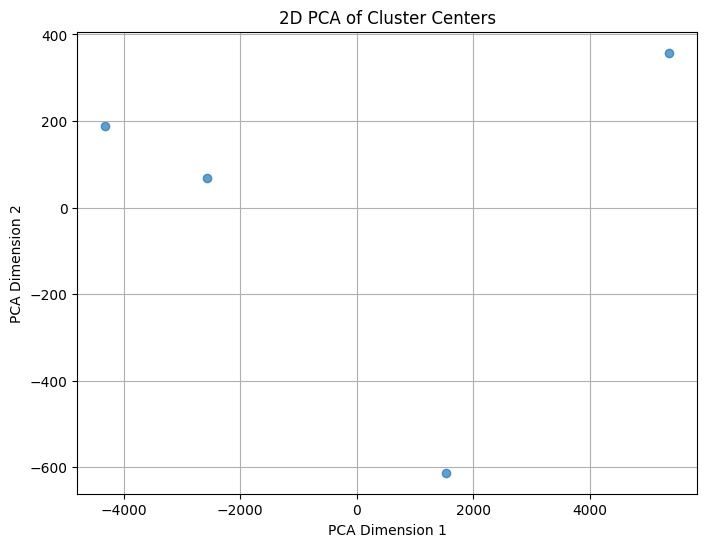

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values
    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)
    return y_new

def load_and_process_data(data_folder, num_points=100):
    processed_data = []
    filenames = []
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            df = df.dropna()
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)
    return np.array(processed_data), filenames

def plot_clusters(data, labels, centers, filenames):
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(2, (n_clusters + 1) // 2, figsize=(15, 8))
    axes = axes.ravel()
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_data = data[labels == i]
        for wave in cluster_data:
            axes[i].plot(np.linspace(0, 1, len(wave)), wave, alpha=0.5, color=colors[i])
        # クラスタ中心をプロット
        axes[i].plot(np.linspace(0, 1, len(centers[i])), centers[i], linewidth=2, color='black', linestyle='--')
        axes[i].set_title(f'Cluster {i}')
        axes[i].set_xlabel('Normalized Strain')
        axes[i].set_ylabel('Stress')

    plt.tight_layout()
    plt.show()

    for i in range(n_clusters):
        print(f"\nCluster {i} files:")
        cluster_files = [filenames[j] for j in range(len(labels)) if labels[j] == i]
        for file in cluster_files:
            print(f"  - {file}")

def main_clustering():
    data_folder = '/content/drive/MyDrive/forecast_LSTM'
    processed_data, filenames = load_and_process_data(data_folder)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)
    centers = kmeans.cluster_centers_
    centers_original = scaler.inverse_transform(centers)  # 中心を元のスケールに戻す
    plot_clusters(processed_data, labels, centers_original, filenames)
    return centers_original

def apply_pca(data):
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)
    return transformed_data, pca

def plot_2d_map(transformed_data, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True)
    plt.show()

def main_pca():
    data_folder = '/content/drive/MyDrive/forecast_LSTM'
    processed_data, filenames = load_and_process_data(data_folder)
    pca_transformed_data, _ = apply_pca(processed_data)
    plot_2d_map(pca_transformed_data, '2D PCA of Waveform Data')
    print("PCA 2D Parameters for Each Data Point:")
    for i, (filename, params) in enumerate(zip(filenames, pca_transformed_data)):
        print(f"{i+1}. File: {filename}, PCA 2D params: {params}")

    # クラスタ中心の次元削減
    centers = main_clustering()
    center_pca_transformed, _ = apply_pca(centers)
    plot_2d_map(center_pca_transformed, '2D PCA of Cluster Centers')

main_pca()

R^2: 0.2753325373512955
Coefficients: [-6.98409889e-06 -1.12330565e-06]
Intercept: 0.16694187943793393


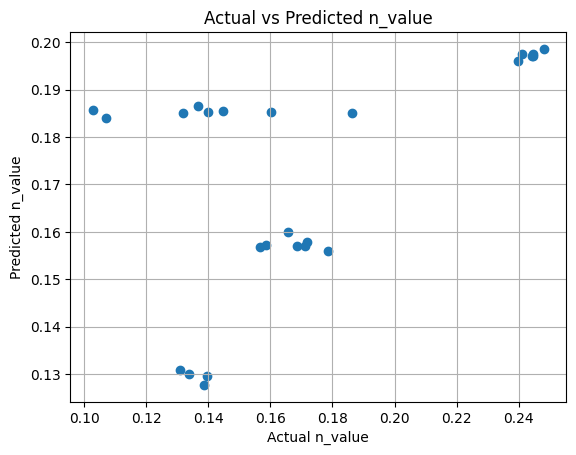

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# n値のデータを読み込む
n_values_path = '/content/drive/MyDrive/n/n_values.csv'
n_values_df = pd.read_csv(n_values_path)

# PCA 2D座標とn値を対応付けるデータフレームを作成
pca_coords = {
    'filename': [
        'F_time_augmented0_forecast.csv', 'F_stress_increase_augmented20_forecast.csv',
        'F_stress_decrease_augmented20_forecast.csv', 'F_time_Lengthened0_forecast.csv',
        'F_strain_augmented00001_forecast.csv', 'M_forecast.csv', 'B_forecast.csv',
        'F-P_forecast.csv', 'F_forecast.csv', 'F-P_noised2_forecast.csv',
        'F-P_stress_decrease_augmented20_forecast.csv', 'F-P_stress_increase_augmented20_forecast.csv',
        'F-P_time_augmented0_forecast.csv', 'F-P_time_Lengthened0_forecast.csv',
        'F-P_strain_augmented00001_forecast.csv', 'F_noised2_forecast.csv',
        'B_noised2_forecast.csv', 'B_time_Lengthened0_forecast.csv',
        'B_stress_increase_augmented20_forecast.csv', 'B_stress_decrease_augmented20_forecast.csv',
        'B_strain_augmented00001_forecast.csv', 'B_time_augmented0_forecast.csv',
        'M_time_Lengthened0_forecast.csv', 'M_noised2_forecast.csv',
        'M_stress_increase_augmented20_forecast.csv'
    ],
    'pca_x': [
        -4351.77750905, -4193.20573832, -4568.29991591, -4400.22880466,
        -4363.17497358, 5135.23435381, 1464.81254312, -2607.82789396,
        -4392.43398682, -2624.33475707, -2838.64407923, -2459.00715142,
        -2647.96858996, -2628.57664083, -2631.03202454, -2683.78578,
        1634.09810479, 1516.29473838, 1573.433231, 1115.57947914,
        1511.10847419, 1435.05946295, 5297.21428904, 5250.08039599,
        5551.1053275
    ],
    'pca_y': [
        256.5072063, 164.4774301, 215.62699371, 142.54775601,
        245.03231553, 195.72248359, -506.35723809, 119.54247932,
        157.52920844, 108.76534815, 120.40642829, 89.47650534,
        37.42188521, 74.18270144, 98.79459562, 0.38796988,
        -314.7205345, -595.49087948, -768.29413613, -811.83574288,
        -506.48833251, -778.20968604, 326.28771318, 285.62061212,
        394.19829283
    ]
}

pca_df = pd.DataFrame(pca_coords)

# n値データとPCA座標データをマージ
merged_df = pd.merge(pca_df, n_values_df, left_on='filename', right_on='Filename')

# 特徴量とターゲット変数を設定
X = merged_df[['pca_x', 'pca_y']]
y = merged_df['n_value']

# 線形回帰モデルの訓練
model = LinearRegression()
model.fit(X, y)

# 回帰モデルの評価
r_squared = model.score(X, y)
print(f'R^2: {r_squared}')

# 回帰係数と切片を表示
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# 予測値のプロット
y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.xlabel('Actual n_value')
plt.ylabel('Predicted n_value')
plt.title('Actual vs Predicted n_value')
plt.grid(True)
plt.show()


R^2: 0.7706606186766195
Coefficients: [ 1.57456381e-04 -1.45422248e-04 -1.65806353e-03  8.86538029e-01]
Intercept: 1.1393939328236322


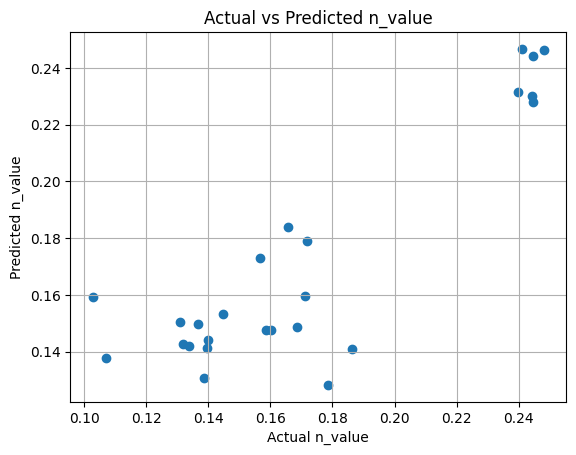

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os

# 真応力と真ひずみを計算する関数
def calculate_true_stress_strain(df):
    df['True Strain'] = np.log(1 + df['Nominal strain'])
    df['True Stress'] = df['Nominal stress'] * (1 + df['Nominal strain'])
    return df

# データを読み込み、真応力と真ひずみを計算する関数
def load_and_process_data(data_folder):
    processed_data = []
    filenames = []
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            df = df.dropna()
            df = calculate_true_stress_strain(df)
            processed_data.append(df)
            filenames.append(filename)
    return processed_data, filenames

# データフォルダのパス
data_folder = '/content/drive/MyDrive/forecast_LSTM'

# データを読み込み、処理
processed_data, filenames = load_and_process_data(data_folder)

# n値のデータを読み込む
n_values_path = '/content/drive/MyDrive/n/n_values.csv'
n_values_df = pd.read_csv(n_values_path)

# PCA 2D座標とn値を対応付けるデータフレームを作成
pca_coords = {
    'filename': [
        'F_time_augmented0_forecast.csv', 'F_stress_increase_augmented20_forecast.csv',
        'F_stress_decrease_augmented20_forecast.csv', 'F_time_Lengthened0_forecast.csv',
        'F_strain_augmented00001_forecast.csv', 'M_forecast.csv', 'B_forecast.csv',
        'F-P_forecast.csv', 'F_forecast.csv', 'F-P_noised2_forecast.csv',
        'F-P_stress_decrease_augmented20_forecast.csv', 'F-P_stress_increase_augmented20_forecast.csv',
        'F-P_time_augmented0_forecast.csv', 'F-P_time_Lengthened0_forecast.csv',
        'F-P_strain_augmented00001_forecast.csv', 'F_noised2_forecast.csv',
        'B_noised2_forecast.csv', 'B_time_Lengthened0_forecast.csv',
        'B_stress_increase_augmented20_forecast.csv', 'B_stress_decrease_augmented20_forecast.csv',
        'B_strain_augmented00001_forecast.csv', 'B_time_augmented0_forecast.csv',
        'M_time_Lengthened0_forecast.csv', 'M_noised2_forecast.csv',
        'M_stress_increase_augmented20_forecast.csv'
    ],
    'pca_x': [
        -4351.77750905, -4193.20573832, -4568.29991591, -4400.22880466,
        -4363.17497358, 5135.23435381, 1464.81254312, -2607.82789396,
        -4392.43398682, -2624.33475707, -2838.64407923, -2459.00715142,
        -2647.96858996, -2628.57664083, -2631.03202454, -2683.78578,
        1634.09810479, 1516.29473838, 1573.433231, 1115.57947914,
        1511.10847419, 1435.05946295, 5297.21428904, 5250.08039599,
        5551.1053275
    ],
    'pca_y': [
        256.5072063, 164.4774301, 215.62699371, 142.54775601,
        245.03231553, 195.72248359, -506.35723809, 119.54247932,
        157.52920844, 108.76534815, 120.40642829, 89.47650534,
        37.42188521, 74.18270144, 98.79459562, 0.38796988,
        -314.7205345, -595.49087948, -768.29413613, -811.83574288,
        -506.48833251, -778.20968604, 326.28771318, 285.62061212,
        394.19829283
    ]
}

pca_df = pd.DataFrame(pca_coords)

# n値データとPCA座標データをマージ
merged_df = pd.merge(pca_df, n_values_df, left_on='filename', right_on='Filename')

# 真応力と真ひずみを追加
true_stress_strain = []
for df in processed_data:
    true_stress_strain.append([df['True Stress'].mean(), df['True Strain'].mean()])

true_stress_strain_df = pd.DataFrame(true_stress_strain, columns=['True Stress', 'True Strain'])
merged_df = pd.concat([merged_df, true_stress_strain_df], axis=1)

# 欠損値を削除
merged_df = merged_df.dropna()

# 特徴量とターゲット変数を設定
X = merged_df[['pca_x', 'pca_y', 'True Stress', 'True Strain']]
y = merged_df['n_value']

# 線形回帰モデルの訓練
model = LinearRegression()
model.fit(X, y)

# 回帰モデルの評価
r_squared = model.score(X, y)
print(f'R^2: {r_squared}')

# 回帰係数と切片を表示
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# 予測値のプロット
y_pred = model.predict(X)
plt.scatter(y, y_pred)
plt.xlabel('Actual n_value')
plt.ylabel('Predicted n_value')
plt.title('Actual vs Predicted n_value')
plt.grid(True)
plt.show()



Loaded 13 files.
Data shape before PCA: (13, 100)
Data shape after PCA: (13, 2)


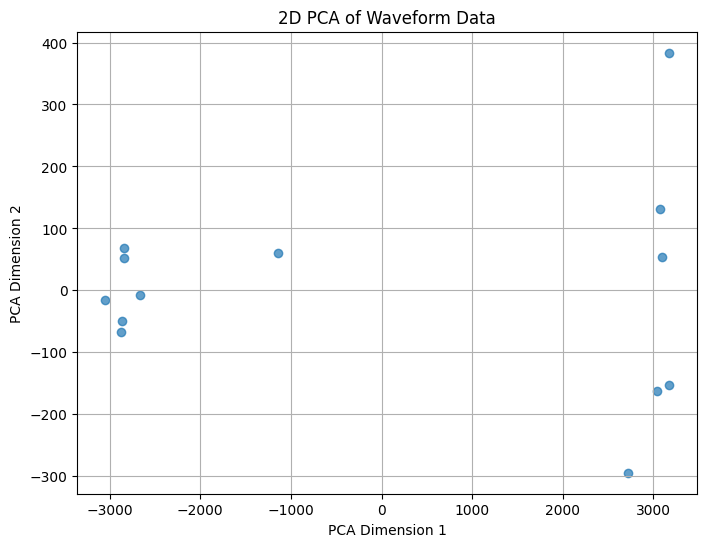

PCA 2D Parameters for Each Data Point:
1. File: F_time_augmented0_forecast.csv, PCA 2D params: [-2837.40692376    67.97167676]
2. File: F_time_Lengthened0_forecast.csv, PCA 2D params: [-2870.39890862   -67.88429126]
3. File: B_stress_decrease_augmented20_forecast.csv, PCA 2D params: [2723.7160994  -294.28767737]
4. File: B_strain_augmented00001_forecast.csv, PCA 2D params: [3076.60866247  131.86929711]
5. File: B_noised2_forecast.csv, PCA 2D params: [3173.52546089  383.56568473]
6. File: F_forecast.csv, PCA 2D params: [-2864.56452211   -48.73360349]
7. File: B_stress_increase_augmented20_forecast.csv, PCA 2D params: [3173.25243497 -153.44899958]
8. File: B_time_Lengthened0_forecast.csv, PCA 2D params: [3094.13340478   54.56831816]
9. File: F_noised2_forecast.csv, PCA 2D params: [-1144.66796388    59.53061768]
10. File: B_time_augmented0_forecast.csv, PCA 2D params: [3037.84071549 -162.73315309]
11. File: F_stress_increase_augmented20_forecast.csv, PCA 2D params: [-2667.71302519    -7.1

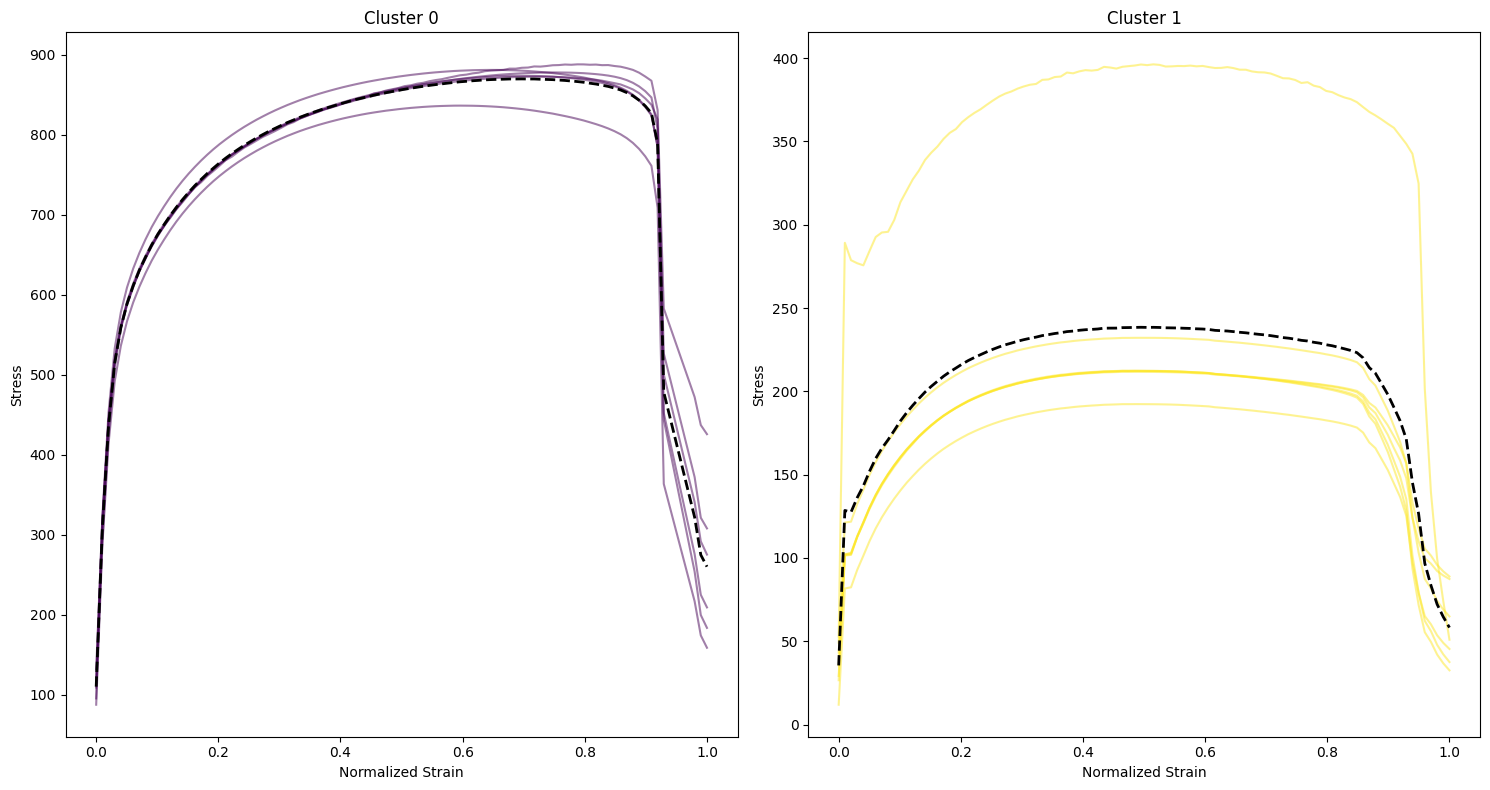


Cluster 0 files:
  - B_stress_decrease_augmented20_forecast.csv
  - B_strain_augmented00001_forecast.csv
  - B_noised2_forecast.csv
  - B_stress_increase_augmented20_forecast.csv
  - B_time_Lengthened0_forecast.csv
  - B_time_augmented0_forecast.csv

Cluster 1 files:
  - F_time_augmented0_forecast.csv
  - F_time_Lengthened0_forecast.csv
  - F_forecast.csv
  - F_noised2_forecast.csv
  - F_stress_increase_augmented20_forecast.csv
  - F_stress_decrease_augmented20_forecast.csv
  - F_strain_augmented00001_forecast.csv
Data shape before PCA: (2, 100)
Data shape after PCA: (2, 2)


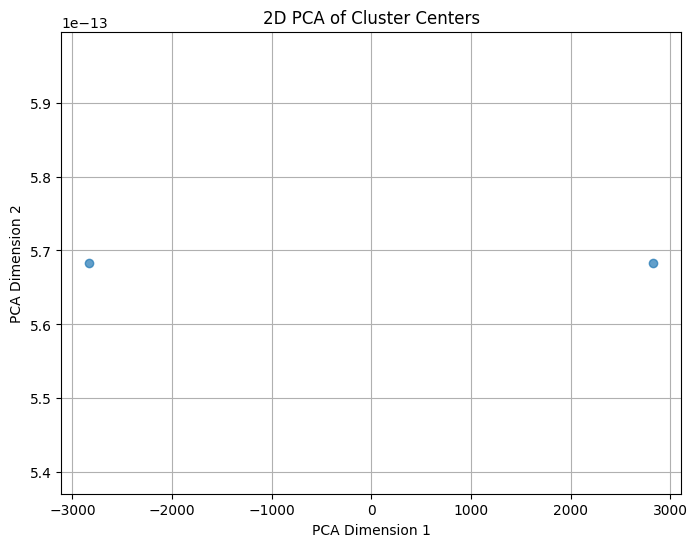

R^2: 0.9813718261626688
Coefficients: [ 3.91539502e-04 -2.94733364e-05 -3.42797276e-03  2.26954563e+00]
Intercept: 1.6381295485740335


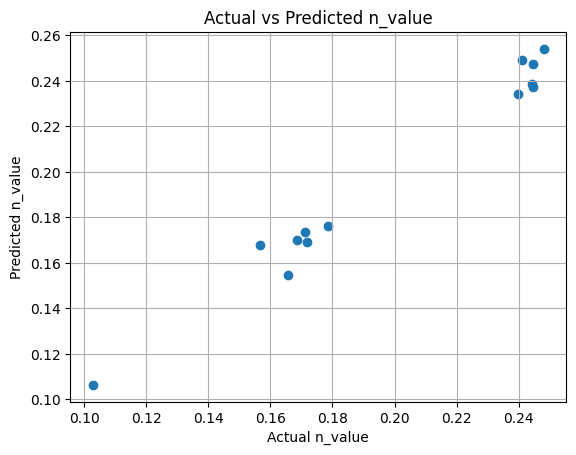

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d

def preprocess_waveform(df, num_points=100):
    x = df['Nominal strain'].values
    y = df['Nominal stress'].values
    f = interp1d(x, y, kind='linear')
    x_new = np.linspace(min(x), max(x), num_points)
    y_new = f(x_new)
    return y_new

def load_and_process_data(data_folder, num_points=100):
    processed_data = []
    filenames = []
    original_data = []
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(data_folder, filename)
            df = pd.read_csv(filepath)
            df = df.dropna()
            processed_wave = preprocess_waveform(df, num_points)
            processed_data.append(processed_wave)
            filenames.append(filename)
            original_data.append(df)
    print(f"Loaded {len(processed_data)} files.")  # デバッグ用
    return np.array(processed_data), filenames, original_data

def plot_clusters(data, labels, centers, filenames):
    n_clusters = len(np.unique(labels))
    fig, axes = plt.subplots(1, n_clusters, figsize=(15, 8))
    axes = axes.ravel()
    colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        cluster_data = data[labels == i]
        for wave in cluster_data:
            axes[i].plot(np.linspace(0, 1, len(wave)), wave, alpha=0.5, color=colors[i])
        # クラスタ中心をプロット
        axes[i].plot(np.linspace(0, 1, len(centers[i])), centers[i], linewidth=2, color='black', linestyle='--')
        axes[i].set_title(f'Cluster {i}')
        axes[i].set_xlabel('Normalized Strain')
        axes[i].set_ylabel('Stress')

    plt.tight_layout()
    plt.show()

    for i in range(n_clusters):
        print(f"\nCluster {i} files:")
        cluster_files = [filenames[j] for j in range(len(labels)) if labels[j] == i]
        for file in cluster_files:
            print(f"  - {file}")

def main_clustering(n_clusters=2):
    data_folder = '/content/drive/MyDrive/forecast_LSTM_F_B'
    processed_data, filenames, original_data = load_and_process_data(data_folder)
    print(f"Processed data shape: {processed_data.shape}")  # デバッグ用
    if processed_data.size == 0:
        print("No data loaded. Please check the data folder and file formats.")
        return None, None, None, None
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(processed_data)
    print(f"Scaled data shape: {data_scaled.shape}")  # デバッグ用
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)
    centers = kmeans.cluster_centers_
    centers_original = scaler.inverse_transform(centers)  # 中心を元のスケールに戻す
    plot_clusters(processed_data, labels, centers_original, filenames)
    return centers_original, filenames, labels, original_data

def apply_pca(data):
    print(f"Data shape before PCA: {data.shape}")  # デバッグ用
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(data)
    print(f"Data shape after PCA: {transformed_data.shape}")  # デバッグ用
    return transformed_data, pca

def plot_2d_map(transformed_data, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.grid(True)
    plt.show()

def main_pca():
    data_folder = '/content/drive/MyDrive/forecast_LSTM_F_B'
    processed_data, filenames, original_data = load_and_process_data(data_folder)
    if processed_data.size == 0:
        print("No data loaded. Please check the data folder and file formats.")
        return None, None, None, None
    pca_transformed_data, _ = apply_pca(processed_data)
    plot_2d_map(pca_transformed_data, '2D PCA of Waveform Data')
    print("PCA 2D Parameters for Each Data Point:")
    for i, (filename, params) in enumerate(zip(filenames, pca_transformed_data)):
        print(f"{i+1}. File: {filename}, PCA 2D params: {params}")

    # クラスタ中心の次元削減
    centers, filenames, labels, original_data = main_clustering(n_clusters=2)
    if centers is None:
        print("Error in clustering. Exiting.")
        return None, None, None, None
    center_pca_transformed, _ = apply_pca(centers)
    plot_2d_map(center_pca_transformed, '2D PCA of Cluster Centers')

    return pca_transformed_data, filenames, labels, original_data

# 実行
pca_transformed_data, filenames, labels, original_data = main_pca()
if pca_transformed_data is None:
    print("Error: No data to process. Exiting.")
else:
    # n値のデータを読み込む
    n_values_path = '/content/drive/MyDrive/n/n_values_F_B.csv'
    n_values_df = pd.read_csv(n_values_path)

    # PCA 2D座標とn値を対応付けるデータフレームを作成
    pca_coords = {
        'filename': filenames,
        'pca_x': pca_transformed_data[:, 0],
        'pca_y': pca_transformed_data[:, 1]
    }

    pca_df = pd.DataFrame(pca_coords)

    # n値データとPCA座標データをマージ
    merged_df = pd.merge(pca_df, n_values_df, left_on='filename', right_on='Filename')

    # 真応力と真ひずみを追加
    true_stress_strain = []
    for df in original_data:
        df = calculate_true_stress_strain(df)
        true_stress_strain.append([df['True Stress'].mean(), df['True Strain'].mean()])

    true_stress_strain_df = pd.DataFrame(true_stress_strain, columns=['True Stress', 'True Strain'])
    merged_df = pd.concat([merged_df, true_stress_strain_df], axis=1)

    # 欠損値を削除
    merged_df = merged_df.dropna()

    # 特徴量とターゲット変数を設定
    X = merged_df[['pca_x', 'pca_y', 'True Stress', 'True Strain']]
    y = merged_df['n_value']

    # 線形回帰モデルの訓練
    model = LinearRegression()
    model.fit(X, y)

    # 回帰モデルの評価
    r_squared = model.score(X, y)
    print(f'R^2: {r_squared}')

    # 回帰係数と切片を表示
    print(f'Coefficients: {model.coef_}')
    print(f'Intercept: {model.intercept_}')

    # 予測値のプロット
    y_pred = model.predict(X)
    plt.scatter(y, y_pred)
    plt.xlabel('Actual n_value')
    plt.ylabel('Predicted n_value')
    plt.title('Actual vs Predicted n_value')
    plt.grid(True)
    plt.show()




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ここでは、すでにリサンプリングされたデータを 'processed_data' と呼びます
# 'processed_data' は (サンプル数, 100) の形状のNumPy配列

# データの標準化
scaler = StandardScaler()
data_scaled = scaler.fit_transform(processed_data)

# PCAによる次元削減
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(data_scaled)

# K-Meansクラスタリング
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(transformed_data)

# プロットの作成
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = transformed_data[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

# クラスタ中心のプロット
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=100, c='black', label='Centers', marker='X')

plt.title('2D PCA of Waveform Data with K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()